Импорты библиотек для всех разделов ноутбука:

In [ ]:
import pandas as pd
import numpy as np
import zipfile
import os
import matplotlib.pyplot as plt
import librosa
import seaborn as sns
import random
import soundfile as sf
import shutil
import torch
import torch.nn as nn
import torchaudio
import torchaudio.transforms as T
import optuna
from collections import Counter
from tqdm.auto import tqdm, trange
from scipy.signal import filtfilt, butter
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import train_test_split
from torchaudio.functional import edit_distance
from torch.utils.tensorboard import SummaryWriter
from torch.amp import GradScaler, autocast
from pyctcdecode import build_ctcdecoder
from Levenshtein import opcodes
from optuna import Trial

## EDA и предобработка

### Распаковка данных

Прочитаем и распакуем архив с данными соревнования:

In [ ]:
path_to_archive = './data/morse-decoder.zip'
path_to_extract = './data/'

with zipfile.ZipFile(path_to_archive, 'r') as z:
    z.extractall(path_to_extract)

os.remove(path_to_archive)

In [5]:
os.listdir(path_to_extract)

['logbook.txt',
 'morse_dataset',
 'sample_submission.csv',
 'test.csv',
 'train.csv']

Получили csv файлы для обучающей и тестовой выборок, пример сабмита, логбук и папку с аудиофайлами. 

### Исследование обучающей и тестовой выборок

Для начала просто посмотрим, как выглядят обучающая и тестовая выборки:

In [8]:
train_df = pd.read_csv(os.path.join(path_to_extract, 'train.csv'))
test_df = pd.read_csv(os.path.join(path_to_extract, 'test.csv'))

train_df.head(5)

,id,message
0,1.opus,03ЩУЫЛПИГХ
1,2.opus,ЪЛТ0ДС6А3Г
2,3.opus,5ЭКЫБЗХЯН
3,4.opus,ЖЫЦОИ68КФ
4,5.opus,32Ю7МЫ ЗЛ


In [9]:
test_df.head(5)

,id
0,30001.opus
1,30002.opus
2,30003.opus
3,30004.opus
4,30005.opus


In [16]:
train_ids = train_df['id'].apply(lambda x: int(x.split('.')[0])).tolist()
assert train_ids == list(range(1, 30001))
test_ids = test_df['id'].apply(lambda x: int(x.split('.')[0])).tolist()
assert test_ids == list(range(30001, 35001))

Обучающая выборка содержит 2 столбца: `id` с именами аудиофайлов от `1.opus` до `30000.opus` и их расшифровкой в текстовом виде. Тестовая выборка - только столбец `id` с именами аудиофайлов от `30001.opus` до `35000.opus`.

Посмотрим, из каких символов состоят сообщения в столбце `message`:

In [19]:
alphabet = set().union(*train_df['message'].apply(lambda x: set(x)))
print(''.join(sorted(alphabet)))

 #0123456789АБВГДЕЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯ


Видим, что имеющийся алфавит - все русские буквы, кроме Ё, все цифры, пробел и символ решетки.

Посмотрим на распределение символов в обучающем наборе:

<Figure size 1000x500 with 0 Axes>

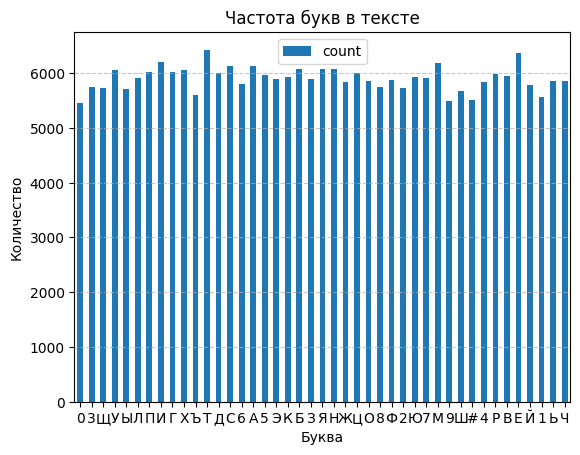

In [22]:
cnt = Counter()
for text in train_df['message']:
    cnt.update(char for char in text if char != ' ')

letter_counts = pd.DataFrame.from_dict(cnt, orient='index', columns=['count'])
plt.figure(figsize=(10, 5))
letter_counts.plot(kind='bar')
plt.title('Частота букв в тексте')
plt.xlabel('Буква')
plt.ylabel('Количество')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=0)
plt.show()

Как видно, небольшой дисбаланс символов все же есть. Но все символы имеют частотность от примерно 5400 до 6400:

In [23]:
letter_counts.describe()

,count
count,43.000000
mean,5904.348837
std,214.621692
min,5450.000000
25%,5772.500000
50%,5903.000000
75%,6034.000000
max,6428.000000


Собственно, посмотрим на сами аудиофайлы. По данной в описании контеста информации, все они записаны с частотой дискретизации 8 кГц. Посмотрим на длительности файлов:

In [25]:
audio_dir = os.path.join(path_to_extract, 'morse_dataset/morse_dataset')
sr = 8000

def get_samples_cnt(audio_name, audio_dir='', sr=8000):
    audio_path = os.path.join(audio_dir, audio_name)
    audio, sr = librosa.load(audio_path, sr=sr)
    return len(audio)

train_lens = train_df['id'].apply(get_samples_cnt, audio_dir=audio_dir)

In [27]:
train_lens.describe()

count    30000.0
mean     64000.0
std          0.0
min      64000.0
25%      64000.0
50%      64000.0
75%      64000.0
max      64000.0
Name: id, dtype: float64

При частоте дискретизации 8 кГц 1 секунда аудио занимает 8000 семплов. Как видим, все аудиофайлы обучающего набора имеют длительности ровно 8 секунд (или 64000 семплов).

Посмотрим длительности тестового набора:

In [28]:
test_lens = test_df['id'].apply(get_samples_cnt, audio_dir=audio_dir)
test_lens.describe()

count      5000.000000
mean      65088.000000
std       18629.161686
min       64000.000000
25%       64000.000000
50%       64000.000000
75%       64000.000000
max      384000.000000
Name: id, dtype: float64

На тестовом наборе уже есть некоторая вариативность - не все аудиофрагменты имеют длину 8 секунд. Из описания известно, что последние 17 файлов могут отличаться. Проверим, отличаются ли только они (судя по перцентилям, скорее всего так и есть) и какие длины тогда у них: 

In [33]:
test_lens_before_last_17 = test_lens.iloc[:-17]
test_lens_before_last_17.describe()

count     4983.0
mean     64000.0
std          0.0
min      64000.0
25%      64000.0
50%      64000.0
75%      64000.0
max      64000.0
Name: id, dtype: float64

In [34]:
test_lens_last_17 = test_lens.iloc[-17:]
test_lens_last_17.describe()

count        17.0
mean     384000.0
std           0.0
min      384000.0
25%      384000.0
50%      384000.0
75%      384000.0
max      384000.0
Name: id, dtype: float64

Видим, что все аудиофайлы тестового набора, кроме последних 17, имеют длину 8 секунд, как и файлы обучающего набора. Последние же 17 файлов занимают 48 секунд (или 384000 семплов).

Больше на тестовом наборе исследований проводиться не будет, т.к. это может привести к утечкам данных и снизит эффективность обучения.

Собственно, посмотрим на сами аудиофайлы. Для удобства задам функцию загрузки аудио по индексу. 

В библиотеке `librosa` есть функция `display.waveplot` для представления аудиосигнала:

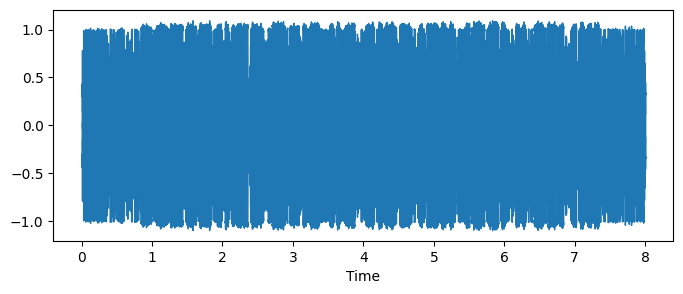

In [45]:
def load_audio(idx):
    path_to_audio = os.path.join(audio_dir, f'{idx}.opus')
    audio, sr = librosa.load(path_to_audio, sr=8000)
    return audio

def display_wave(audio):
    plt.figure(figsize=(8, 3))
    librosa.display.waveshow(audio, sr=8000)

idx = 1
audio = load_audio(idx)
display_wave(audio)

Кажется, из такого представления обучить что-то выделять сигналы проблематично.

В логбуке было рекомендовано использовать мел-фильтр и спектрограмму. В `librosa` можно получить представление аудиофайла с помощью мел-спектрограммы. Я пробовала различные значения параметра `n_fft` (число преобразований Фурье) и заметила, что лучше всего сигнал выделяется при значении `n_fft = 256`. Что касается `hop_length` (шаг между окнами), его рекомендуется устанавливать как `n_fft // 4`.


Также в ходе моего мини-исследования я узнала (например, в [этой](https://medium.com/analytics-vidhya/understanding-the-mel-spectrogram-fca2afa2ce53) статье), что часто рекомендуют преобразовывать амплитуды полученной мел-спектрограммы в децибелы. Такое преобразование переводит действительные значения амплитуды в логарифмическую шкалу. Это приводит к тому, что слабые сигналы становятся более различимыми. Такая шкала переводит данные в формат, похожий на то, как человеческое ухо воспринимает звук.

В `librosa` для этого есть функция `librosa.amplitude_to_db`

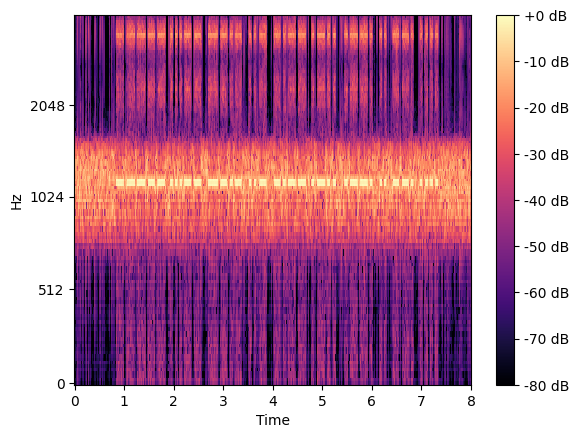

In [56]:
def plot_spec(audio):
    mel_spec = librosa.feature.melspectrogram(
        y=audio,
        sr=8000,
        n_fft=256,
        hop_length=64
    )
    mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
    librosa.display.specshow(mel_spec, sr=sr, hop_length=64, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.show()

audio = load_audio(1)
plot_spec(audio)

В первом аудиофайле уже четко видно сигнал. Также видны шумы: узкополосный шум вокруг сигнала и шумы на других частотах из-за искажения сигнала. Посмотрим еще один файл, где шумов больше:

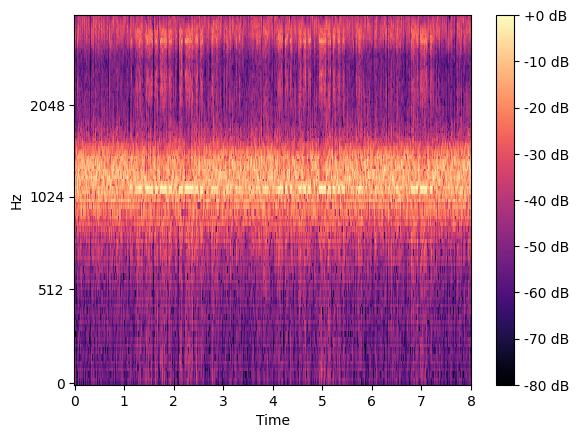

In [57]:
audio = load_audio(2)
plot_spec(audio)

Здесь видим, что с периодичностью ~3 секунды шум заглушает сигнал, но при этом какая-то его часть все равно видна. Также фоновый шум в этом примере сильнее, чем в предыдущем. 

Но такое представление все еще кажется избыточным: сигнал сосредоточен в небольшом диапазоне частот, тогда как на остальных частотах шумы. Эмпирическим путем я обнаружила, что оптимально брать 6 частот с максимальным средним значением. Визуально это будет выглядеть так:

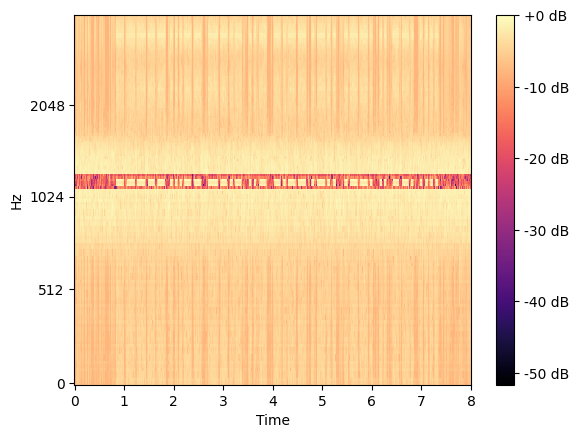

In [123]:
def plot_spec(audio, crop=False, normalize=False):
    mel_spec = librosa.feature.melspectrogram(
        y=audio,
        sr=8000,
        n_fft=256,
        hop_length=64
    )
    mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
    if crop:
        means = mel_spec.mean(axis=1)
        all_freqs = np.arange(mel_spec.shape[0])
        sig_freqs = np.sort(np.argsort(means)[-6:])
        no_sig_freqs = all_freqs[~np.isin(all_freqs, sig_freqs)]
        mask = np.ones_like(mel_spec)
        mask[no_sig_freqs, :] *= 0.1
        mel_spec = mel_spec * mask
        if normalize:
            signal = mel_spec[sig_freqs]
            signal = (signal - signal.mean()) / (signal.std() + 1e-8)
            mel_spec[sig_freqs] = signal
            mask[no_sig_freqs, :] *= 0.7
            mel_spec = mel_spec * mask
    librosa.display.specshow(mel_spec, sr=sr, hop_length=64, x_axis='time', y_axis='mel', cmap='magma')
    plt.colorbar(format='%+2.0f dB')
    plt.show()

audio = load_audio(1)
plot_spec(audio, crop=True)

Для этого примера количество частот избыточно, но есть примеры, где сигнал захватывает больше частот. Тем не менее, иногда такой подход захватывает зашумленные частоты. Изначально я пробовала брать 3 частоты, но эксперименты показали, что выделение 6 частот дает результат лучше (сравнивала 1, 3, 6 и 10 частот).

Для улучшения сходимости выделенный сигнал также нормализуется: из него вычитается среднее и полученное значение делится на стандартное отклонение. Для зашумленного аудио (2) видно, что сигнал выделяется немного лучше после нормализации:  

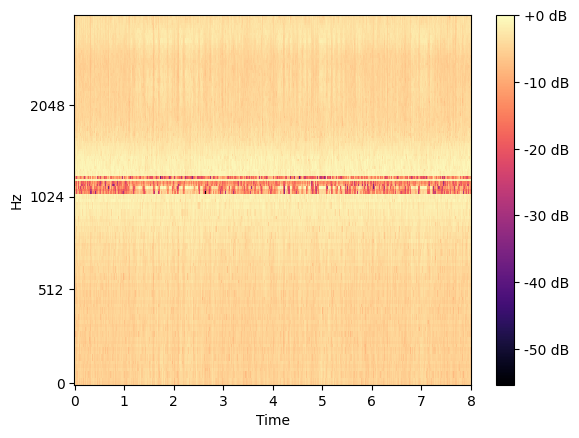

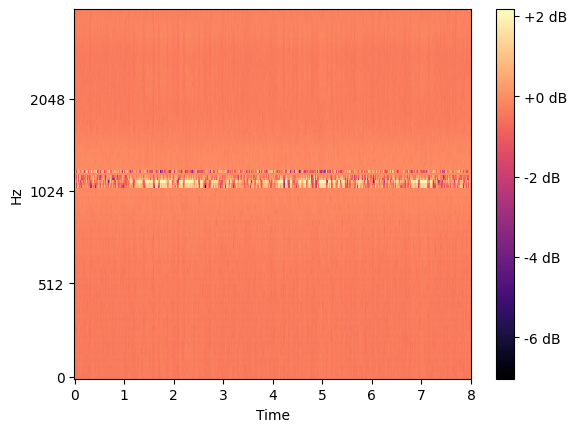

In [124]:
audio = load_audio(2)
plot_spec(audio, crop=True)
plot_spec(audio, crop=True, normalize=True)

Итого при обучении предобработка выглядит так: сигнал преобразуется в мел-спектрограмму с параметрами `n_fft=256`, `hop_length=64`, затем амплитуда преобразуется в дБ, выделяется 6 частот с  максимальным средним значением сигнала, а затем полученная матрица нормализуется.

В ходе работы (для генерации синтетических данных) мне понадобилась и другая информация об аудиофайлах. В частности, частоты, на которых передается сигнал. Посмотрим, на каких частотах передается сигнал в обучающем наборе, для этого возьмем строку спектрограммы с максимальным средним значением и с помощью `librosa.mel_frequencies` переведем индекс этой строки в значение частоты.

In [138]:
pitches = []

for i in trange(1, 30001):
    audio = load_audio(i)
    mel_spec = librosa.feature.melspectrogram(
        y=audio,
        sr=8000,
        n_fft=256,
        hop_length=64
    )
    mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
    means = mel_spec.mean(axis=1)
    max_sig_idx = np.argmax(means)
    mel_frequencies = librosa.mel_frequencies(n_mels=mel_spec.shape[0], fmin=0, fmax=sr/2)
    signal_freq = mel_frequencies[max_sig_idx]
    pitches.append(signal_freq)

  0%|          | 0/30000 [00:00<?, ?it/s]

<Axes: ylabel='Count'>

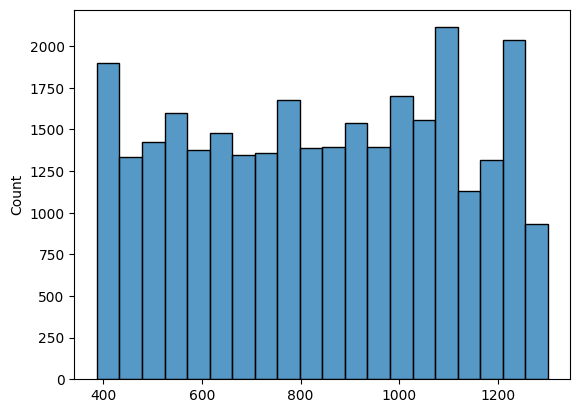

In [144]:
sns.histplot(data=pitches, bins=20)

In [145]:
pitches = np.array(pitches)
pitches.min(), pitches.max()

(387.63200346821503, 1301.0489389907543)

Распределение похоже на равномерное, но некоторые частоты выделяются.

### Предобработка сообщений

Я решила обучать модель предсказывать не буквы, а непосредственно символы, из которых состоит азбука Морзе: точки, тире и пробелы (между символами и между словами) - преобразовать одно в другое несложно и не затратно по времени, в то время как простой модели будет проще обучиться непосредственно на те сигналы, которые содержатся в аудио, чем еще и учиться преобразовывать их в символы. 

Поэтому для обучения необходимо преобразовать сообщения в столбце `messages` в код Морзе.

Как было видно в ходе предобработки, в сообщениях содержатся буквы русского алфавита, цифры и символ решетки. Расшифровку букв и цифр легко нагуглить, но вот решетку так просто не получилось найти, поэтому посмотрим по спектрограмме, как она закодирована.

Для начала найдем сообщения, содержащие решетку, и получим соответствующие имена файлов.

In [126]:
has_hash = train_df[train_df['message'].str.find('#') > 0]
has_hash

,id,message
6,7.opus,УЗОЗ#Г8
13,14.opus,ОТЩ 71#С0Р
17,18.opus,Ю#ЗЕ5ТШБ
20,21.opus,3Я0Д# ЫЯЗ
22,23.opus,Д #7КЕКВГН5С
...,...,...
29966,29967.opus,ТТ1ВМ#ФВУУ
29979,29980.opus,И6 2#У1ЗМ
29985,29986.opus,6ПЩТР#ФЙ
29987,29988.opus,68БЯВ#


И посмотрим на спектрограммы пары примеров, чтобы удостовериться, что все верно:

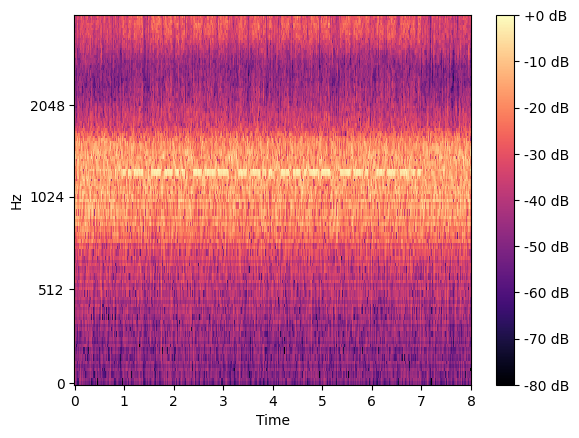

In [127]:
plot_spec(load_audio(7))

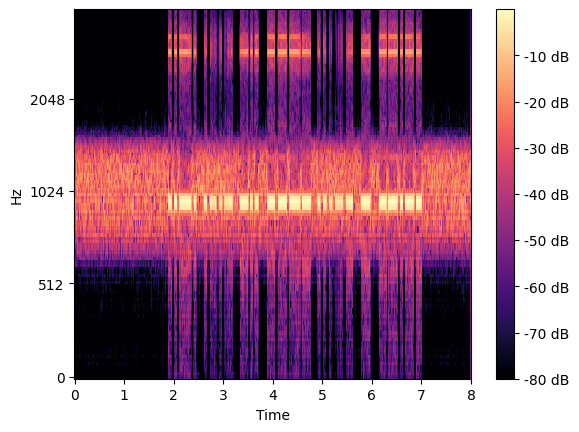

In [128]:
plot_spec(load_audio(29999))

Видим, что решетка закодирована как `--.--`.

В качестве разделителя между символами используется знак `$`, а между словами - `/`.
Теперь можем составить словарь для преобразования символов в код Морзе и, собственно, преобразовать их:

In [129]:
morse_dict = {
    '.-': 'А', '-...': 'Б', '.--': 'В', '--.': 'Г', '-..': 'Д', '.': 'Е', '...-': 'Ж', '--..': 'З',
    '..': 'И', '.---': 'Й', '-.-': 'К', '.-..': 'Л', '--': 'М', '-.': 'Н', '---': 'О', '.--.': 'П',
    '.-.': 'Р', '...': 'С', '-': 'Т', '..-': 'У', '..-.': 'Ф', '....': 'Х', '-.-.': 'Ц', '---.': 'Ч',
    '----': 'Ш', '--.-': 'Щ', '.--.-.': 'Ъ',
    '-..-': 'Ь', '-.--': 'Ы', '..-..': 'Э', '..--': 'Ю', '.-.-': 'Я', '.----': '1', '..---': '2',
    '...--': '3', '....-': '4', '.....': '5', '-....': '6', '--...': '7', '---..': '8', '----.': '9',
    '-----': '0', '--.--': '#'
}
char2morse = dict(zip(morse_dict.values(), morse_dict.keys()))

def text_to_morse(text):
    morse_code = []
    for char in text.upper():
        if char in char2morse:
            morse_code.append(char2morse[char])
            morse_code.append('$')
        elif char == ' ':
            morse_code.pop()
            morse_code.append('/')
        else:
            print(f'shouldnt be here! text: {text}, char: {char}')
            morse_code.append('?')
    morse_code.pop()
    return ''.join(morse_code)

train_df['morse'] = train_df['message'].apply(text_to_morse)
train_df.head(5)

,id,message,morse
0,1.opus,03ЩУЫЛПИГХ,-----$...--$--.-$..-$-.--$.-..$.--.$..$--.$....
1,2.opus,ЪЛТ0ДС6А3Г,.--.-.$.-..$-$-----$-..$...$-....$.-$...--$--.
2,3.opus,5ЭКЫБЗХЯН,.....$..-..$-.-$-.--$-...$--..$....$.-.-$-.
3,4.opus,ЖЫЦОИ68КФ,...-$-.--$-.-.$---$..$-....$---..$-.-$..-.
4,5.opus,32Ю7МЫ ЗЛ,...--$..---$..--$--...$--$-.--/--..$.-..


Видим, что преобразование прошло успешно, и никаких ошибок не возникло (иначе бы вывелся print с ошибкой).

## Генерация синтетических данных

В ходе моих экспериментов мне захотелось посмотреть, улучшит ли добавление новых данных в обучающий набор качество работы модели (спойлер - улучшило). Поэтому итоговая модель была обучена на 70000 дополнительных к обучающему набору сгенерированных примерах.

Основа кода для генерации данных была взята из [этого](https://github.com/pd0wm/nn-morse/blob/master/morse.py) репозитория и немного изменена. 

Сначала определим функцию генерации шума. Судя по просмотренным спектрограммам, на аудиофайлах есть узкополосный шум вокруг сигнала и иногда присутствует фоновый шум. 

Определим функцию, которая будет генерировать узкополосный шум на частотах от `low_cut` до `high_cut` и, если флаг `white=True`, добавлять общий белый шум к узкополосному.

Белый шум генерируется стандартно, из нормального распределения. Затем для того, чтобы сделать из него узкополосный шум, применяется `butter` и `filtfilt` из `scipy.signal` - применяем фильтр Баттерворта к шуму. Затем шум нормализуется делением на максимальное значение по модулю и умножается на 0.5, чтобы не перебивать сигнал (параметры подбирались визуально по спектрограмме). Фоновый белый шум прибавляется со множителем 0.01, чтобы оставаться фоновым.

In [151]:
def generate_noise(duration_sec, sample_rate=8000, low_cut=500, high_cut=900, noise_power=1, white=True):
    samples = int(duration_sec * sample_rate)
    noise_power = 1e-6 * noise_power * 4000
    white_noise = np.random.normal(scale=np.sqrt(noise_power), size=samples)


    nyquist = 0.5 * sample_rate
    low = low_cut / nyquist
    high = high_cut / nyquist
    b, a = butter(5, [low, high], btype='band')

    bandpass_noise = filtfilt(b, a, white_noise)
    bandpass_noise = bandpass_noise / np.max(np.abs(bandpass_noise)) * 0.5
    if white:
        bandpass_noise += 0.01 * white_noise
    return bandpass_noise

Также я постаралась сделать генерацию семплов так, чтобы выровнять частоту встречаемости символов. Для этого вычислим веса, с которыми будем выбирать символы при генерации строк, основываясь на частоте встречаемости символов в обучающем наборе. Вес (он же вероятность выбора символа) обратно пропорционален частоте встречаемости символа в обучающем наборе:

In [152]:
cnt = Counter()
for text in train_df['message']:
    cnt.update(char for char in text if char != ' ')

alphabet = list(cnt.keys())
weights = {char: 1./freq for char, freq in cnt.items()}
total = sum(weights.values())
norm_weights = {char: w/total for char, w in weights.items()}
alphabet, weights = list(norm_weights.keys()), list(norm_weights.values())

Теперь определим функцию генерации семплов.

Функция принимает параметры:

- `text_len` - длина строки (с пробелами),

- `pitch` - частота передачи сигнала,

- `wpm` - words-per-minute, скорость передачи,

- `loudness` - громкость сигнала,

- `distort` - уровень искажения сигнала,

- `white` - наличие фонового шума,

- `start` - длина паузы до начала передачи (в длинах передачи точки).


В ходе моего ресерча я узнала, что принято, что длина передачи тире равна 3 длинам передачи точки, пауза внутри символа - длительности 1 точки, пауза между символами - длительности 3 точек, и пауза между словами - длительности 7 точек. Это учтено в процессе генерации (и уже было в коде, взятом из репозитория).

Символы для генерации выбираются случайно с вычисленными выше весами. В ходе написания этого решения я поняла, что в последней версии генерации данных в алфавите нет пробела - досадное упущение (в предыдущих версиях он был), но итоговая модель вполне неплохо обучилась и без этого. 

Длительность точки берется из нормального распределения со средним 1 и стандартным отклонением 0.2 и клипируется до адекватных параметров (0.5, 2). Остальные длительности высчитываются относительно семплированной длительности точки - тем самым, в одном фрагменте длины могут варьироваться, т.к. для каждого символа (точка, тире и т.п.) семплирование выполняется отдельно.

В качестве попытки приблизить искажение звука, как в данном датасете, я добавила функцию гиперболического тангенса `np.tanh`, в которой величина искажения регулируется параметром `distort`. Степень искажения регулировалась "на глаз", путем сравнения полученных спектрограмм со спектрограммами файлов из данного датасета.

In [153]:
def gen_morse(text_len=14, pitch=1100, wpm=20, loudness=0.5, distort=2, white=True, start=10):
    dot = (60 / wpm) / 50 * 8000

    def get_dot():
        scale = np.clip(np.random.normal(1, 0.2), 0.5, 2.0)
        return int(dot * scale)

    def get_dash():
        return int(3 * get_dot())

    s = ''.join(random.choices(alphabet, weights=weights, k=text_len))
    encoded_text = []
    out = [np.zeros(int(start * get_dot()))]

    target_length = 8 * 8000
    current_length = out[0].shape[0]
    final_text = ""
    final_encoded_text = []

    for c in s:
        if c == ' ':
            if not final_encoded_text or final_encoded_text and final_encoded_text[-1] == ' ':
                continue
            encoded_text.append(' ')
            pause = np.zeros(7 * get_dot())
        else:
            morse_code = char2morse[c]
            encoded_text.append(morse_code)
            letter_audio = []

            for m in morse_code:
                if m == '.':
                    letter_audio.append(np.ones(get_dot()))
                    letter_audio.append(np.zeros(get_dot()))
                elif m == '-':
                    letter_audio.append(np.ones(get_dash()))
                    letter_audio.append(np.zeros(get_dot()))
            letter_audio.append(np.zeros(2 * get_dot()))
            letter_audio = np.hstack(letter_audio)
            pause = letter_audio

        if current_length + len(pause) > target_length - 2000:
            break

        out.append(pause)
        current_length += len(pause)
        final_text += c
        final_encoded_text.append(encoded_text[-1])

    out = np.hstack(out)
    out = out[:target_length]
    if out.shape[0] < target_length:
        out = np.pad(out, (0, target_length - out.shape[0]), mode='constant')
    t = np.arange(len(out)) / 8000
    sine = np.sin(2 * np.pi * pitch * t)
    
    noise = generate_noise(8, low_cut=pitch-200, high_cut=pitch+200, noise_power=1, white=white)
    
    out = noise + out * sine * loudness
    out = np.tanh(distort * out)

    out = np.clip(out, -1, 1).astype(np.float32)

    return out, final_text, ' '.join(final_encoded_text)

Посмотрим на примеры сгенерированных данных:

64000 АЮ6Й3Б477 .- ..-- -.... .--- ...-- -... ....- --... --...


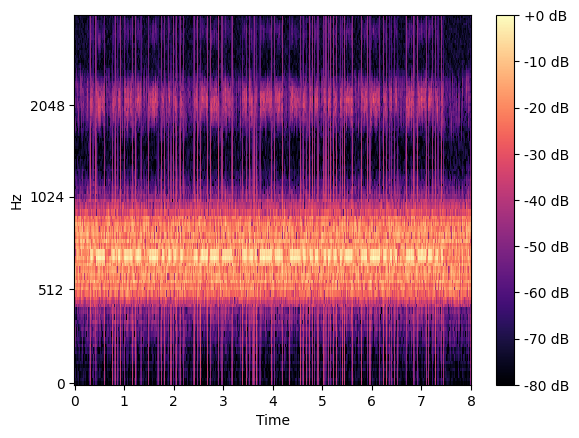

In [154]:
audio, text, encoded_text = gen_morse(wpm=20, pitch=700, white=True, loudness=0.3, distort=2, start=5)
print(len(audio), text, encoded_text)
plot_spec(audio)

В целом похоже на спектрограммы из данного датасета. Еще пример с бОльшим искажением и меньшей громкостью сигнала:

64000 5ЦДКЪ6ЬАЩ ..... -.-. -.. -.- .--.-. -.... -..- .- --.-


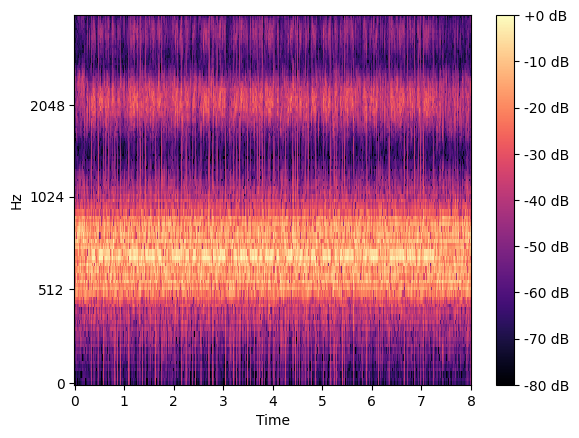

In [156]:
audio, text, encoded_text = gen_morse(wpm=20, pitch=700, white=True, loudness=0.2, distort=5, start=5)
print(len(audio), text, encoded_text)
plot_spec(audio)

Я не стала варьировать ширину узкополосного шума (в исходном датасете он часто несимметричен относительно сигнала), т.к. все равно в модель подаются только частоты с наибольшим значением сигнала, так что расположение шума вокруг него не играет слишком большой роли.

Для генерации будем варьировать параметры с помощью их семплирования из различных распределений. По большей части параметры распределений подбирались на глаз. Pitch подбирался по EDA, wpm - исходя из общих соображений о скорости передачи, start, distortion, white, loudness - исходя из просмотренных спектрограмм файлов исходного датасета.

In [157]:
def sample_params():
    pitch = np.random.uniform(140, 480) * 3
    loudness = np.clip(np.random.normal(0.3, 0.1), 0.05, 0.55) 
    distort = np.clip(np.random.normal(5, 2), 0.1, 10.0)
    start = np.clip(np.random.normal(10, 3), 1, 20)
    white = np.random.choice([True, False], p=[0.7, 0.3])
    wpm = np.clip(np.random.normal(20, 5), 10, 30).astype(int)
    return pitch, loudness, distort, start, white, wpm

texts = []
morses = []

Собственно, генерация файлов. Файлы сохранила в формате `flac`, т.к. `wav` уж очень много весит, а для `opus` надо было ставить больше зависимостей.

In [ ]:
dir_path = './data/morse_dataset/100k_balanced/'
for i in tqdm(range(35001, 105001)):
    pitch, loudness, distort, start, white, wpm = sample_params()
    
    audio, text, morse = gen_morse(
        pitch=pitch,
        loudness=loudness,
        distort=distort,
        start=start,
        white=white,
        wpm=wpm
    )
    texts.append(text)
    morses.append(morse)

    # сохраняем .flac
    sf.write(f'{dir_path}{i}.flac', audio, samplerate=8000, format='FLAC')

100%|██████████| 70000/70000 [1:00:23<00:00, 19.32it/s]


Дополним датасет исходными файлами:

In [ ]:
src_dir = './data/morse_dataset/morse_dataset/'

for i in trange(1, 35001):
    src = os.path.join(src_dir, f'{i}.opus')
    dst = os.path.join(dir_path, f'{i}.opus')
    shutil.copy(src, dst)

100%|██████████| 35000/35000 [05:53<00:00, 98.93it/s] 


Посмотрим несколько примеров сгенерированных строк:

In [ ]:
texts[-10:]

['Р9УЖЩМЦКЭ4',
 'ЩФ3А0ЙК',
 '27АБ6СЧТ',
 'КОПВЬ',
 '763Д',
 'Ч6РДК#',
 'ГЩКХЮКУЙАЖ',
 'Я7ФВ4Ь',
 'ММОНП27Д',
 'ЙЧЭЯЩЗТБЖ']

Выглядит вполне похоже на обучающий набор!

Дополним датафрейм с обучающей выборкой новыми данными:

In [ ]:
train_df = pd.read_csv('./data/train.csv')

filenames = [f'{i}.flac' for i in range(35001, 105001)]
new_data = pd.DataFrame({
    'id': filenames,
    'message': texts
})
df = pd.concat([train_df, new_data], ignore_index=True)
df

,id,message
0,1.opus,03ЩУЫЛПИГХ
1,2.opus,ЪЛТ0ДС6А3Г
2,3.opus,5ЭКЫБЗХЯН
3,4.opus,ЖЫЦОИ68КФ
4,5.opus,32Ю7МЫ ЗЛ
...,...,...
99995,104996.flac,Ч6РДК#
99996,104997.flac,ГЩКХЮКУЙАЖ
99997,104998.flac,Я7ФВ4Ь
99998,104999.flac,ММОНП27Д


Добавим преобразование из символов в Морзе:

In [ ]:
df['morse'] = df['message'].apply(text_to_morse)
df

,id,message,morse
0,1.opus,03ЩУЫЛПИГХ,-----$...--$--.-$..-$-.--$.-..$.--.$..$--.$....
1,2.opus,ЪЛТ0ДС6А3Г,.--.-.$.-..$-$-----$-..$...$-....$.-$...--$--.
2,3.opus,5ЭКЫБЗХЯН,.....$..-..$-.-$-.--$-...$--..$....$.-.-$-.
3,4.opus,ЖЫЦОИ68КФ,...-$-.--$-.-.$---$..$-....$---..$-.-$..-.
4,5.opus,32Ю7МЫ ЗЛ,...--$..---$..--$--...$--$-.--/--..$.-..
...,...,...,...
99995,104996.flac,Ч6РДК#,---.$-....$.-.$-..$-.-$--.--
99996,104997.flac,ГЩКХЮКУЙАЖ,--.$--.-$-.-$....$..--$-.-$..-$.---$.-$...-
99997,104998.flac,Я7ФВ4Ь,.-.-$--...$..-.$.--$....-$-..-
99998,104999.flac,ММОНП27Д,--$--$---$-.$.--.$..---$--...$-..


И сохраним полученный датафрейм:

In [ ]:
df.to_csv('./data/train_100k_balanced.csv', index=False)

Посмотрим, как теперь выглядит распределение символов:

<Figure size 1000x500 with 0 Axes>

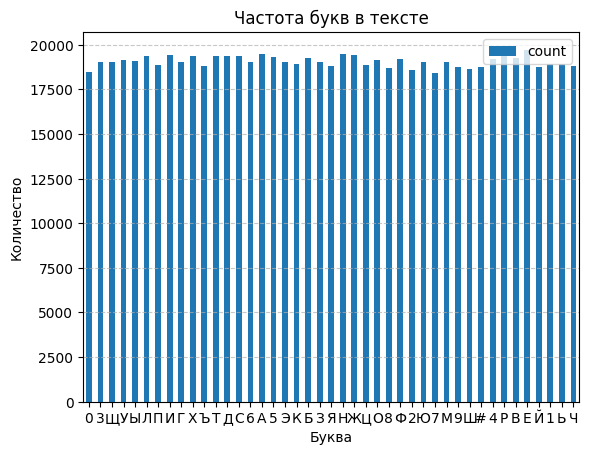

In [ ]:
cnt = Counter()
for text in df['message']:
    cnt.update(char for char in text if char != ' ')

letter_counts = pd.DataFrame.from_dict(cnt, orient='index', columns=['count'])
plt.figure(figsize=(10, 5))
letter_counts.plot(kind='bar')
plt.title('Частота букв в тексте')
plt.xlabel('Буква')
plt.ylabel('Количество')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Да, баланс все еще неидеальный, но в любом случае символы более сбалансированы, чем в исходном наборе. Плюс у модели теперь будет бОльшее разнообразие примеров!

## Обучение

При необходимости, задаем видеокарту, на которой будем обучаться (у меня эта необходимость была):

In [ ]:
os.environ['CUDA_VISIBLE_DEVICES'] = '6'

Читаем датафрейм с обучающим набором. Столбец `morse` уже содержит преобразованные в морзе сообщения. `train_dict` нужен для подачи в класс Dataset (можно было бы и обрабатывать датафрейм, конечно, но мне показалось, что так удобнее).

In [ ]:
train_df = pd.read_csv('./data/train_100k_balanced.csv')
train_dict = dict(zip(train_df['id'], train_df['morse']))

Заранее определим все необходимые функции для декодирования морзе обратно в символы. `decode_morse`, собственно, это и делает. `remove_repeated` удаляет повторяющиеся символы в последовательности токенов (которые возникнут из-за особенностей лосса).

In [ ]:
morse_dict = {
    '.-': 'А', '-...': 'Б', '.--': 'В', '--.': 'Г', '-..': 'Д', '.': 'Е', '...-': 'Ж', '--..': 'З',
    '..': 'И', '.---': 'Й', '-.-': 'К', '.-..': 'Л', '--': 'М', '-.': 'Н', '---': 'О', '.--.': 'П',
    '.-.': 'Р', '...': 'С', '-': 'Т', '..-': 'У', '..-.': 'Ф', '....': 'Х', '-.-.': 'Ц', '---.': 'Ч',
    '----': 'Ш', '--.-': 'Щ', '.--.-.': 'Ъ',
    '-..-': 'Ь', '-.--': 'Ы', '..-..': 'Э', '..--': 'Ю', '.-.-': 'Я', '.----': '1', '..---': '2',
    '...--': '3', '....-': '4', '.....': '5', '-....': '6', '--...': '7', '---..': '8', '----.': '9',
    '-----': '0', '--.--': '#'
}

def decode_morse(s):
    if not s:
        return s
    words = s.split('/')
    decoded_words = []
    for word in words:
        symbols = word.split('$')
        decoded_symbols = [morse_dict.get(sym.replace('?', ''), '') for sym in symbols if sym]
        decoded_word = ''.join(decoded_symbols)
        decoded_words.append(decoded_word)
    return ' '.join(decoded_words)

def remove_repeated(pred):
    cleaned = []
    prev = None
    for symbol in pred:
        if symbol != prev:
            cleaned.append(symbol)
            prev = symbol
    return cleaned

Определим класс токенизатора. Добавим в список токенов `<pad>` для паддинга. Токены `<sos>`, `<eos>` в текущей версии решения не используются (остались от попыток использовать трансформер). Токен `?` также в этой версии не используется и остался от предыдущих, где была ошибка в дешифровке (вместо русской Е я по ошибке указала английскую...). Токен `<blank>` нужен для CTCLoss.

В остальном, токенизатор просто преобразует токены в их индексы (`encode`) или обратно (`decode`).

In [ ]:
class MorseTokenizer:
    def __init__(self):
        self.chars = ['<pad>', '<sos>', '<eos>'] + list("-.$/?") + ['<blank>']
        self.char2idx = {ch: i for i, ch in enumerate(self.chars)}
        self.idx2char = {i: ch for ch, i in self.char2idx.items()}

    def encode(self, text):
        return [self.char2idx.get(c, 7) for c in text.lower()]

    def decode(self, tokens):
        return ''.join([self.idx2char[tok] for tok in tokens if tok > 2 and tok != 8])

    def vocab_size(self):
        return len(self.chars)

Загружать данные в память не хочется, поэтому нужны `Dataset` и `Dataloader`. Определим класс `SpectrogramDataset`. При инициализации ему подается словарь с именами аудиофайлов и соответствующими сообщениями, путь к папке с аудиофайлами, токенизатор, sample_rate (здесь он задан по умолчанию) и флаг использования аугментаций.

В `__getitem__` по индексу берется соответствующий аудиофайл, грузится с помощью `torchaudio.load` (чтобы сразу работать с тензорами), строится его мел-спектрограмма, переводится в дБ и берутся 6 частот с максимальными средними значениями, после чего полученный тензор нормализуется (все в точности так же, как указано в предобработке, только с использованием torchaudio).

Если передан флаг использования аугментаций `aug`, то с вероятностью 0.3 зануляется случайная частота (строка) спектрограммы.

Сообщения токенизируются и преобразуются в тензор.

In [ ]:
class SpectrogramDataset(Dataset):
    def __init__(self, audio_dir, transcription_dict, tokenizer, sample_rate=8000, aug=False):
        self.audio_files = list(transcription_dict.keys())
        self.transcriptions = transcription_dict
        self.tokenizer = tokenizer
        self.audio_dir = audio_dir
        self.sample_rate = sample_rate
        self.mel = T.MelSpectrogram(sample_rate=sample_rate, n_fft=256, hop_length=64)
        self.db = T.AmplitudeToDB()
        self.do_aug=aug

    def __len__(self):
        return len(self.audio_files)

    def __getitem__(self, idx):
        file = self.audio_files[idx]
        path = os.path.join(self.audio_dir, file)
        waveform, sr = torchaudio.load(path)
        if sr != self.sample_rate:
            waveform = torchaudio.functional.resample(waveform, sr, self.sample_rate)
        
        waveform = waveform.mean(dim=0)

        mel_spec = self.mel(waveform)
        mel_spec = self.db(mel_spec)
        mel_spec = self._get_signal(mel_spec)
        if self.do_aug:
            mel_spec = self.channel_dropout(mel_spec)
        mel_spec = self._normalize_spec(mel_spec)

        text = self.transcriptions[file]
        token_ids = self.tokenizer.encode(text)
        return mel_spec, torch.tensor(token_ids, dtype=torch.long)

    def _get_signal(self, mel_spec):
        means = mel_spec.mean(dim=1)
        sig = np.sort(np.argsort(means)[-6:])
        mel_spec = mel_spec[sig]
        return mel_spec

    def _normalize_spec(self, spec):
        spec = (spec - spec.mean()) / (spec.std() + 1e-8)
        return spec

    def channel_dropout(self, x, drop_prob=0.3):
        if torch.rand(1).item() > drop_prob:
            return x
        idx = torch.randint(0, x.size(0), (1,))
        x[idx, :] = 0
        return x

Чтобы батчи были консистентными по размеру, нужна `collate_fn`. Она добавляет паддинг со значением 0 к спектрограммам и таргетам (сообщениям).

In [ ]:
def collate_fn(batch):
    specs, targets = zip(*batch)
    specs = nn.utils.rnn.pad_sequence(specs, batch_first=True)
    targets = nn.utils.rnn.pad_sequence(targets, batch_first=True, padding_value=0)
    return specs, targets

И, собственно, определим модель. Изначально она планировалась быть бейзлайн-решением (только с другими параметрами, поменьше), но в итоге в ходе моих экспериментов другие архитектуры не достигли большего скора. 

Архитектура довольно простая: два сверточных слоя с активацией между ними. Добавление активации после них ухудшало скор: рекуррентной сети важно видеть исходные зависимости, а активации могут их нарушить. Свертки 1d, т.к. наши данные вытянуты "в ширину", но в длину их укорачивать не надо, частот и так немного.

Далее идет пятислойная двунаправленная GRU. В ходе моего ресерча мне часто попадались модели CNN + RNN для задач ASR, в том числе расшифровки Морзе. Плюс такая архитектура выглядит несложно, поэтому мой выбор пал на нее.

Наконец, после GRU линейным слоем преобразуем выходы GRU в вектор логитов размерности, равной размерности алфавита. 

Параметры модели подбирались несколько раз через optuna, код будет представлен ниже. Актуальные параметры, использованные при обучении, указаны в определении модели в ячейке ниже.

In [160]:
class SimpleSeqModel(nn.Module):
    def __init__(self, input_dim, vocab_size, conv1_out=64, conv2_out=128, hidden_dim=256, num_layers=2, dropout=0):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(in_channels=input_dim, out_channels=conv1_out, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv1d(conv1_out, conv2_out, kernel_size=3, stride=2)
        )
        self.rnn = nn.GRU(
            input_size=conv2_out,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout
        )
        self.fc = nn.Linear(hidden_dim * 2, vocab_size)

    def forward(self, x):
        x = self.conv(x)
        out, _ = self.rnn(x.permute(0, 2, 1))  # (B, C, T) -> (B, T, C) - в gru подаем по одному временному шагу 
        logits = self.fc(out)
        return logits

Определим токенизатор, датасеты, даталоадеры. Для train берем датасет с аугментациями, для val - датасет без аугментаций. Также для валидации берем только аудиофайлы из исходного датасета, из первых 30000 файлов. 

В качестве оптимизатора берем `AdamW` со значением `lr=1e-4` - оно оказалось самым оптимальным в ходе экспериментов. Но чтобы не ходить вокруг да около минимума, добавим шедулер, который будет снижать lr в два раза, если за 3 эпохи значение метрики на валидации не улучшилось.

Определяем имя эксперимента, чекпоинта, задаем папки с чекпоинтами и логами, чтобы все это дело сохранять и записывать. Записывать графики будем через `tensorboard SummaryWriter`. 

Также определим `GradScaler`, чтобы использовать при обучении mixed precision и чуть быстрее получать результат.

In [ ]:
tokenizer = MorseTokenizer()
batch_size = 32
dataset_aug = SpectrogramDataset(
        audio_dir='./morse-decoder/morse-100b/100k_balanced',
        transcription_dict=train_dict,
        tokenizer=tokenizer,
        aug=True
)
dataset = SpectrogramDataset(
        audio_dir='./morse-decoder/morse-100b/100k_balanced',
        transcription_dict=train_dict,
        tokenizer=tokenizer
)
indices = list(range(30000))
train_idx, val_idx = train_test_split(indices, test_size=0.2, random_state=1337)
train_idx = train_idx + list(range(30000, len(dataset)))
train_dataset = Subset(dataset_aug, train_idx)
val_dataset = Subset(dataset, val_idx)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, num_workers=8, 
                          pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, num_workers=8, 
                        pin_memory=True)
 
model = SimpleSeqModel(input_dim=6, vocab_size=tokenizer.vocab_size(), conv1_out=128, conv2_out=256, num_layers=5, hidden_dim=512, dropout=0.46)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

experiment_name = "gru1/100kb_aug2_l"
checkpoint_dir = "checkpoints"
checkpoint_name = "gru1_100kb_aug2_l"
logs_dir = "./logs/" + experiment_name
writer = SummaryWriter(logs_dir)
scaler = GradScaler('cuda')

/home/anikinain/envs/speech_venv/lib/python3.10/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (129) may be set too low.
  warnings.warn(


Определим функции вычисления лосса и метрики (расстояние Левенштейна a.k.a. редакторское расстояние), чтобы не писать код два раза для трейна и валидации. 

Самый интересный экземпляр здесь (по крайней мере, для меня) - `ctc_loss`. Этот лосс позволяет решать seq2seq задачу со входами и выходами разной длины. Для работы ему нужны логарифмы вероятностей символов, вытянутые в вектор таргеты, длины входов, длины выходов и индекс `<blank>` токена. При этом длина входной последовательности должна быть больше выходной (как это часто бывает в задачах ASR). Тогда на каждый шаг входа модель может генерировать токен, но при этом лосс будет учитывать идущие подряд одинаковые токены как один, тем самым выравнивая выходную последовательность так, чтобы она совпадала по длине со входной после обучения. `<blank>` токен нужен для пустоты между токенами, он не учитывается в лоссе, но нужен, к примеру, чтобы отделить друг от друга два подряд идущих одинаковых токена.

Параметр `time_steps` - значение размерности T в батче размерностью B x T x F. После применения сверток из изначальных 1001 временных шагов получаем 249.

Метрика вычисляется с помощью функции `edit_distance` из torchaudio. При этом в выходной последовательности сначала склеиваются подряд идущие одинаковые токены и удаляются служебные (паддинг, бланк). Метрика считается как средняя метрика по батчу. 

In [ ]:
def compute_logits_loss(model, spec, targets, batch_size=32, time_steps=249):
    device = spec.device
    with autocast(device_type='cuda', enabled=True):
        input_lengths = torch.full((spec.shape[0],), time_steps, dtype=torch.long).to(device)
        logits = model(spec)
        log_probs = nn.functional.log_softmax(logits, dim=-1).permute(1, 0, 2)
        target_lengths = (targets != 0).sum(dim=1).to(device).long()
        targets_flat = []
        for seq, length in zip(targets, target_lengths):
            targets_flat.append(seq[:length])
        targets_flat = torch.cat([s for s in targets_flat]).to(device)
        loss = nn.functional.ctc_loss(
            log_probs=log_probs,
            targets=targets_flat,
            input_lengths=input_lengths,
            target_lengths=target_lengths,
            blank=8
        )
    return logits, loss

def compute_levdist_avg_batch(preds, targets, show=False):
    batch_dist = 0
    batch_size = preds.shape[0]
    for i, seq in enumerate(preds):
        morse_pred = tokenizer.decode(remove_repeated(seq.tolist()))
        morse_target = tokenizer.decode(targets[i, :].tolist())
        decoded_pred = decode_morse(morse_pred)
        decoded_target = decode_morse(morse_target)
        dist = edit_distance(decoded_pred, decoded_target)
        batch_dist += dist
        if show:
            print("Pred:", morse_pred)
            print(f'Target: {morse_target}')
            print(f'Decoded (pred): {decoded_pred}')
            print(f'Decoded (target): {decoded_target}')
            print(f'LevDist: {dist}')
    return batch_dist / batch_size

Наконец, определим и запустим train_loop. Будем обучать модель в течение 100 эпох с early stopping в случае, если метрика не улучшается после 10 эпох. Вычисляем и выводим в прогресс-баре значения лосса и метрики на трейне и валидации. Записываем их в логи. Также сохраняем чекпоинт в случае улучшения метрики на валидации.

In [ ]:
EPOCHS = 100

model = model.to(device)
best_val_dist = float('inf')
no_improve = 0
patience = 10
for epoch in range(EPOCHS):
    cur_lr = scheduler.get_last_lr()[0]
    model.train()
    total_loss = 0
    total_train_dist = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")
    for spectrograms, targets in progress_bar:
        spectrograms = spectrograms.to(device)
        optimizer.zero_grad()
        logits, loss = compute_logits_loss(model, spectrograms, targets, batch_size=batch_size)
        preds = logits.detach().argmax(dim=-1)
        avg_batch_dist = compute_levdist_avg_batch(preds, targets)
        total_train_dist += avg_batch_dist
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()
        writer.add_scalar('Loss/train_batch', loss.item(), global_step=epoch * (progress_bar.n + 1))
        progress_bar.set_postfix({'loss': total_loss / (progress_bar.n + 1), 
                                  'LevDist': total_train_dist / (progress_bar.n + 1), 
                                  'lr': cur_lr})

    avg_train_dist = total_train_dist / len(train_loader)
    avg_loss = total_loss / len(train_loader)
    writer.add_scalar('Loss/train_epoch', avg_loss, epoch)
    writer.add_scalar('LevDist/train_epoch', avg_train_dist, epoch)
    print(f"Epoch {epoch + 1}, Loss: {avg_loss:.4f}, LevDist: {avg_train_dist:.4f}")

    total_dist = 0
    total_val_loss = 0
    model.eval()
    progress_bar_val = tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")
    with torch.no_grad():
        for spectrograms, targets in progress_bar_val:
            spectrograms = spectrograms.to(device)
            cur_dist = 0
            logits, loss = compute_logits_loss(model, spectrograms, targets, batch_size=batch_size)
            total_val_loss += loss.item()
            preds = logits.argmax(dim=-1)
            avg_batch_dist_val = compute_levdist_avg_batch(preds, targets)
            total_dist += avg_batch_dist_val
            progress_bar_val.set_postfix({'loss': total_val_loss / (progress_bar_val.n + 1), 
                                          'LevDist': total_dist / (progress_bar_val.n + 1),
                                          'lr': cur_lr})
    avg_val_dist = total_dist / len(val_loader)
    avg_val_loss = total_val_loss / len(val_loader)
    writer.add_scalar('Loss/val_epoch', avg_val_loss, epoch)
    writer.add_scalar('LevDist/val_epoch', avg_val_dist, epoch)
    print(f'Total loss (val): {avg_val_loss:.4f}, total dist (val): {avg_val_dist:.4f}')
    writer.add_scalar('LR', optimizer.param_groups[0]['lr'], epoch)

    scheduler.step(avg_val_dist)

    if avg_val_dist < best_val_dist:
        best_val_dist = avg_val_dist
        no_improve = 0
        checkpoint_path = os.path.join(checkpoint_dir, checkpoint_name + f'.pth')
        torch.save({
            "epoch": epoch + 1,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "scheduler_state_dict": scheduler.state_dict(),
            "best_val_dist": best_val_dist
        }, checkpoint_path)
        print(f"✅ Model improved! Saved checkpoint: {checkpoint_path}")
    else:
        no_improve += 1
        if no_improve >= patience:
            print(f'Early stopping on epoch {epoch + 1}')
            break

Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?
Space token ' ' missing from vocabulary.
Epoch 1/100: 100%|████████████████████████████████████████████████████████| 2938/2938 [05:38<00:00,  8.69it/s, loss=0.375, LevDist=2.8, lr=0.0001]


Epoch 1, Loss: 0.3748, LevDist: 2.7996


Epoch 1/100: 100%|███████████████████████████████████████████████████████| 188/188 [00:30<00:00,  6.23it/s, loss=0.0554, LevDist=0.577, lr=0.0001]


Total loss (val): 0.0551, total dist (val): 0.5738
✅ Model improved! Saved checkpoint: checkpoints/gru1_100kb_aug2.pth


Epoch 2/100: 100%|█████████████████████████████████████████████████████| 2938/2938 [05:34<00:00,  8.78it/s, loss=0.0781, LevDist=0.809, lr=0.0001]


Epoch 2, Loss: 0.0781, LevDist: 0.8091


Epoch 2/100: 100%|███████████████████████████████████████████████████████| 188/188 [00:29<00:00,  6.45it/s, loss=0.0453, LevDist=0.467, lr=0.0001]


Total loss (val): 0.0451, total dist (val): 0.4649
✅ Model improved! Saved checkpoint: checkpoints/gru1_100kb_aug2.pth


Epoch 3/100: 100%|██████████████████████████████████████████████████████| 2938/2938 [05:42<00:00,  8.57it/s, loss=0.068, LevDist=0.712, lr=0.0001]


Epoch 3, Loss: 0.0680, LevDist: 0.7118


Epoch 3/100: 100%|█████████████████████████████████████████████████████████| 188/188 [00:29<00:00,  6.28it/s, loss=0.0389, LevDist=0.4, lr=0.0001]


Total loss (val): 0.0385, total dist (val): 0.3956
✅ Model improved! Saved checkpoint: checkpoints/gru1_100kb_aug2.pth


Epoch 4/100: 100%|█████████████████████████████████████████████████████| 2938/2938 [06:46<00:00,  7.22it/s, loss=0.0584, LevDist=0.623, lr=0.0001]


Epoch 4, Loss: 0.0584, LevDist: 0.6232


Epoch 4/100: 100%|███████████████████████████████████████████████████████| 188/188 [00:32<00:00,  5.83it/s, loss=0.0317, LevDist=0.346, lr=0.0001]


Total loss (val): 0.0316, total dist (val): 0.3441
✅ Model improved! Saved checkpoint: checkpoints/gru1_100kb_aug2.pth


Epoch 5/100: 100%|█████████████████████████████████████████████████████| 2938/2938 [10:32<00:00,  4.65it/s, loss=0.0534, LevDist=0.577, lr=0.0001]


Epoch 5, Loss: 0.0534, LevDist: 0.5769


Epoch 5/100: 100%|█████████████████████████████████████████████████████████| 188/188 [02:01<00:00,  1.54it/s, loss=0.036, LevDist=0.36, lr=0.0001]


Total loss (val): 0.0356, total dist (val): 0.3561


Epoch 6/100: 100%|█████████████████████████████████████████████████████| 2938/2938 [11:11<00:00,  4.37it/s, loss=0.0508, LevDist=0.547, lr=0.0001]


Epoch 6, Loss: 0.0508, LevDist: 0.5467


Epoch 6/100: 100%|███████████████████████████████████████████████████████| 188/188 [00:34<00:00,  5.48it/s, loss=0.0291, LevDist=0.322, lr=0.0001]


Total loss (val): 0.0291, total dist (val): 0.3218
✅ Model improved! Saved checkpoint: checkpoints/gru1_100kb_aug2.pth


Epoch 7/100: 100%|█████████████████████████████████████████████████████| 2938/2938 [10:29<00:00,  4.66it/s, loss=0.0487, LevDist=0.528, lr=0.0001]


Epoch 7, Loss: 0.0487, LevDist: 0.5284


Epoch 7/100: 100%|███████████████████████████████████████████████████████| 188/188 [00:35<00:00,  5.34it/s, loss=0.0284, LevDist=0.295, lr=0.0001]


Total loss (val): 0.0284, total dist (val): 0.2950
✅ Model improved! Saved checkpoint: checkpoints/gru1_100kb_aug2.pth


Epoch 8/100: 100%|█████████████████████████████████████████████████████| 2938/2938 [10:29<00:00,  4.67it/s, loss=0.0464, LevDist=0.505, lr=0.0001]


Epoch 8, Loss: 0.0464, LevDist: 0.5050


Epoch 8/100: 100%|███████████████████████████████████████████████████████| 188/188 [00:31<00:00,  5.89it/s, loss=0.0272, LevDist=0.292, lr=0.0001]


Total loss (val): 0.0270, total dist (val): 0.2904
✅ Model improved! Saved checkpoint: checkpoints/gru1_100kb_aug2.pth


Epoch 9/100: 100%|██████████████████████████████████████████████████████| 2938/2938 [10:30<00:00,  4.66it/s, loss=0.0449, LevDist=0.49, lr=0.0001]


Epoch 9, Loss: 0.0449, LevDist: 0.4896


Epoch 9/100: 100%|███████████████████████████████████████████████████████| 188/188 [00:31<00:00,  6.04it/s, loss=0.0262, LevDist=0.283, lr=0.0001]


Total loss (val): 0.0261, total dist (val): 0.2819
✅ Model improved! Saved checkpoint: checkpoints/gru1_100kb_aug2.pth


Epoch 10/100: 100%|████████████████████████████████████████████████████| 2938/2938 [10:33<00:00,  4.64it/s, loss=0.0435, LevDist=0.477, lr=0.0001]


Epoch 10, Loss: 0.0435, LevDist: 0.4765


Epoch 10/100: 100%|██████████████████████████████████████████████████████| 188/188 [00:32<00:00,  5.80it/s, loss=0.0251, LevDist=0.263, lr=0.0001]


Total loss (val): 0.0251, total dist (val): 0.2628
✅ Model improved! Saved checkpoint: checkpoints/gru1_100kb_aug2.pth


Epoch 11/100: 100%|████████████████████████████████████████████████████| 2938/2938 [10:29<00:00,  4.67it/s, loss=0.0422, LevDist=0.461, lr=0.0001]


Epoch 11, Loss: 0.0422, LevDist: 0.4614


Epoch 11/100: 100%|██████████████████████████████████████████████████████| 188/188 [00:35<00:00,  5.25it/s, loss=0.0255, LevDist=0.271, lr=0.0001]


Total loss (val): 0.0254, total dist (val): 0.2699


Epoch 12/100: 100%|█████████████████████████████████████████████████████| 2938/2938 [10:25<00:00,  4.69it/s, loss=0.041, LevDist=0.452, lr=0.0001]


Epoch 12, Loss: 0.0410, LevDist: 0.4521


Epoch 12/100: 100%|██████████████████████████████████████████████████████| 188/188 [00:34<00:00,  5.40it/s, loss=0.0244, LevDist=0.254, lr=0.0001]


Total loss (val): 0.0243, total dist (val): 0.2523
✅ Model improved! Saved checkpoint: checkpoints/gru1_100kb_aug2.pth


Epoch 13/100: 100%|████████████████████████████████████████████████████| 2938/2938 [10:34<00:00,  4.63it/s, loss=0.0403, LevDist=0.444, lr=0.0001]


Epoch 13, Loss: 0.0403, LevDist: 0.4443


Epoch 13/100: 100%|██████████████████████████████████████████████████████| 188/188 [00:32<00:00,  5.77it/s, loss=0.0254, LevDist=0.265, lr=0.0001]


Total loss (val): 0.0253, total dist (val): 0.2631


Epoch 14/100: 100%|████████████████████████████████████████████████████| 2938/2938 [10:32<00:00,  4.65it/s, loss=0.0392, LevDist=0.433, lr=0.0001]


Epoch 14, Loss: 0.0392, LevDist: 0.4333


Epoch 14/100: 100%|███████████████████████████████████████████████████████| 188/188 [00:32<00:00,  5.79it/s, loss=0.025, LevDist=0.244, lr=0.0001]


Total loss (val): 0.0250, total dist (val): 0.2438
✅ Model improved! Saved checkpoint: checkpoints/gru1_100kb_aug2.pth


Epoch 15/100: 100%|█████████████████████████████████████████████████████| 2938/2938 [10:32<00:00,  4.65it/s, loss=0.0389, LevDist=0.43, lr=0.0001]


Epoch 15, Loss: 0.0389, LevDist: 0.4303


Epoch 15/100: 100%|██████████████████████████████████████████████████████| 188/188 [00:33<00:00,  5.58it/s, loss=0.0226, LevDist=0.235, lr=0.0001]


Total loss (val): 0.0226, total dist (val): 0.2350
✅ Model improved! Saved checkpoint: checkpoints/gru1_100kb_aug2.pth


Epoch 16/100: 100%|████████████████████████████████████████████████████| 2938/2938 [10:32<00:00,  4.64it/s, loss=0.0379, LevDist=0.422, lr=0.0001]


Epoch 16, Loss: 0.0379, LevDist: 0.4218


Epoch 16/100: 100%|██████████████████████████████████████████████████████| 188/188 [00:33<00:00,  5.62it/s, loss=0.0241, LevDist=0.251, lr=0.0001]


Total loss (val): 0.0241, total dist (val): 0.2510


Epoch 17/100: 100%|████████████████████████████████████████████████████| 2938/2938 [10:32<00:00,  4.64it/s, loss=0.0372, LevDist=0.416, lr=0.0001]


Epoch 17, Loss: 0.0372, LevDist: 0.4161


Epoch 17/100: 100%|██████████████████████████████████████████████████████| 188/188 [00:32<00:00,  5.77it/s, loss=0.0237, LevDist=0.242, lr=0.0001]


Total loss (val): 0.0235, total dist (val): 0.2404


Epoch 18/100: 100%|█████████████████████████████████████████████████████| 2938/2938 [10:29<00:00,  4.67it/s, loss=0.0364, LevDist=0.41, lr=0.0001]


Epoch 18, Loss: 0.0364, LevDist: 0.4095


Epoch 18/100: 100%|███████████████████████████████████████████████████████| 188/188 [00:33<00:00,  5.58it/s, loss=0.0239, LevDist=0.24, lr=0.0001]


Total loss (val): 0.0239, total dist (val): 0.2395


Epoch 19/100: 100%|█████████████████████████████████████████████████████| 2938/2938 [10:30<00:00,  4.66it/s, loss=0.036, LevDist=0.404, lr=0.0001]


Epoch 19, Loss: 0.0360, LevDist: 0.4037


Epoch 19/100: 100%|███████████████████████████████████████████████████████| 188/188 [00:33<00:00,  5.66it/s, loss=0.024, LevDist=0.243, lr=0.0001]


Total loss (val): 0.0240, total dist (val): 0.2430


Epoch 20/100: 100%|███████████████████████████████████████████████████████| 2938/2938 [10:32<00:00,  4.64it/s, loss=0.0332, LevDist=0.38, lr=5e-5]


Epoch 20, Loss: 0.0332, LevDist: 0.3798


Epoch 20/100: 100%|████████████████████████████████████████████████████████| 188/188 [00:34<00:00,  5.50it/s, loss=0.0228, LevDist=0.226, lr=5e-5]


Total loss (val): 0.0227, total dist (val): 0.2252
✅ Model improved! Saved checkpoint: checkpoints/gru1_100kb_aug2.pth


Epoch 21/100: 100%|███████████████████████████████████████████████████████| 2938/2938 [10:33<00:00,  4.64it/s, loss=0.0324, LevDist=0.37, lr=5e-5]


Epoch 21, Loss: 0.0324, LevDist: 0.3702


Epoch 21/100: 100%|████████████████████████████████████████████████████████| 188/188 [00:29<00:00,  6.33it/s, loss=0.0222, LevDist=0.219, lr=5e-5]


Total loss (val): 0.0221, total dist (val): 0.2176
✅ Model improved! Saved checkpoint: checkpoints/gru1_100kb_aug2.pth


Epoch 22/100: 100%|██████████████████████████████████████████████████████| 2938/2938 [10:41<00:00,  4.58it/s, loss=0.0315, LevDist=0.364, lr=5e-5]


Epoch 22, Loss: 0.0315, LevDist: 0.3635


Epoch 22/100: 100%|█████████████████████████████████████████████████████████| 188/188 [00:29<00:00,  6.48it/s, loss=0.0233, LevDist=0.22, lr=5e-5]


Total loss (val): 0.0233, total dist (val): 0.2199


Epoch 23/100: 100%|███████████████████████████████████████████████████████| 2938/2938 [10:45<00:00,  4.55it/s, loss=0.0309, LevDist=0.36, lr=5e-5]


Epoch 23, Loss: 0.0309, LevDist: 0.3597


Epoch 23/100: 100%|████████████████████████████████████████████████████████| 188/188 [00:28<00:00,  6.54it/s, loss=0.0238, LevDist=0.221, lr=5e-5]


Total loss (val): 0.0237, total dist (val): 0.2202


Epoch 24/100: 100%|██████████████████████████████████████████████████████| 2938/2938 [10:44<00:00,  4.56it/s, loss=0.0304, LevDist=0.352, lr=5e-5]


Epoch 24, Loss: 0.0304, LevDist: 0.3519


Epoch 24/100: 100%|████████████████████████████████████████████████████████| 188/188 [00:30<00:00,  6.17it/s, loss=0.0237, LevDist=0.221, lr=5e-5]


Total loss (val): 0.0236, total dist (val): 0.2196


Epoch 25/100: 100%|████████████████████████████████████████████████████████| 2938/2938 [10:50<00:00,  4.52it/s, loss=0.03, LevDist=0.348, lr=5e-5]


Epoch 25, Loss: 0.0300, LevDist: 0.3479


Epoch 25/100: 100%|██████████████████████████████████████████████████████████| 188/188 [00:27<00:00,  6.85it/s, loss=0.024, LevDist=0.22, lr=5e-5]


Total loss (val): 0.0240, total dist (val): 0.2199


Epoch 26/100: 100%|████████████████████████████████████████████████████| 2938/2938 [10:49<00:00,  4.52it/s, loss=0.0286, LevDist=0.333, lr=2.5e-5]


Epoch 26, Loss: 0.0286, LevDist: 0.3334


Epoch 26/100: 100%|██████████████████████████████████████████████████████| 188/188 [00:27<00:00,  6.78it/s, loss=0.0237, LevDist=0.216, lr=2.5e-5]


Total loss (val): 0.0237, total dist (val): 0.2161
✅ Model improved! Saved checkpoint: checkpoints/gru1_100kb_aug2.pth


Epoch 27/100: 100%|████████████████████████████████████████████████████| 2938/2938 [10:46<00:00,  4.54it/s, loss=0.0278, LevDist=0.329, lr=2.5e-5]


Epoch 27, Loss: 0.0278, LevDist: 0.3292


Epoch 27/100: 100%|██████████████████████████████████████████████████████| 188/188 [00:27<00:00,  6.80it/s, loss=0.0244, LevDist=0.216, lr=2.5e-5]


Total loss (val): 0.0244, total dist (val): 0.2163


Epoch 28/100: 100%|████████████████████████████████████████████████████| 2938/2938 [10:45<00:00,  4.55it/s, loss=0.0275, LevDist=0.324, lr=2.5e-5]


Epoch 28, Loss: 0.0275, LevDist: 0.3238


Epoch 28/100: 100%|██████████████████████████████████████████████████████| 188/188 [00:28<00:00,  6.70it/s, loss=0.0243, LevDist=0.221, lr=2.5e-5]


Total loss (val): 0.0243, total dist (val): 0.2212


Epoch 29/100: 100%|████████████████████████████████████████████████████| 2938/2938 [10:56<00:00,  4.48it/s, loss=0.0272, LevDist=0.323, lr=2.5e-5]


Epoch 29, Loss: 0.0272, LevDist: 0.3228


Epoch 29/100: 100%|██████████████████████████████████████████████████████| 188/188 [00:27<00:00,  6.75it/s, loss=0.0245, LevDist=0.216, lr=2.5e-5]


Total loss (val): 0.0245, total dist (val): 0.2156
✅ Model improved! Saved checkpoint: checkpoints/gru1_100kb_aug2.pth


Epoch 30/100: 100%|████████████████████████████████████████████████████| 2938/2938 [10:59<00:00,  4.46it/s, loss=0.0268, LevDist=0.319, lr=2.5e-5]


Epoch 30, Loss: 0.0268, LevDist: 0.3192


Epoch 30/100: 100%|████████████████████████████████████████████████████████| 188/188 [00:28<00:00,  6.71it/s, loss=0.025, LevDist=0.22, lr=2.5e-5]


Total loss (val): 0.0248, total dist (val): 0.2186


Epoch 31/100: 100%|████████████████████████████████████████████████████| 2938/2938 [11:00<00:00,  4.45it/s, loss=0.0265, LevDist=0.317, lr=2.5e-5]


Epoch 31, Loss: 0.0265, LevDist: 0.3170


Epoch 31/100: 100%|███████████████████████████████████████████████████████| 188/188 [00:28<00:00,  6.70it/s, loss=0.025, LevDist=0.213, lr=2.5e-5]


Total loss (val): 0.0248, total dist (val): 0.2121
✅ Model improved! Saved checkpoint: checkpoints/gru1_100kb_aug2.pth


Epoch 32/100: 100%|████████████████████████████████████████████████████| 2938/2938 [10:47<00:00,  4.54it/s, loss=0.0262, LevDist=0.314, lr=2.5e-5]


Epoch 32, Loss: 0.0262, LevDist: 0.3138


Epoch 32/100: 100%|██████████████████████████████████████████████████████| 188/188 [00:26<00:00,  7.00it/s, loss=0.0262, LevDist=0.219, lr=2.5e-5]


Total loss (val): 0.0260, total dist (val): 0.2174


Epoch 33/100: 100%|█████████████████████████████████████████████████████| 2938/2938 [10:45<00:00,  4.55it/s, loss=0.026, LevDist=0.312, lr=2.5e-5]


Epoch 33, Loss: 0.0260, LevDist: 0.3118


Epoch 33/100: 100%|██████████████████████████████████████████████████████| 188/188 [00:27<00:00,  6.84it/s, loss=0.0257, LevDist=0.216, lr=2.5e-5]


Total loss (val): 0.0255, total dist (val): 0.2144


Epoch 34/100: 100%|████████████████████████████████████████████████████| 2938/2938 [07:08<00:00,  6.85it/s, loss=0.0256, LevDist=0.307, lr=2.5e-5]


Epoch 34, Loss: 0.0256, LevDist: 0.3069


Epoch 34/100: 100%|██████████████████████████████████████████████████████| 188/188 [00:27<00:00,  6.85it/s, loss=0.0255, LevDist=0.218, lr=2.5e-5]


Total loss (val): 0.0255, total dist (val): 0.2183


Epoch 35/100: 100%|████████████████████████████████████████████████████| 2938/2938 [07:08<00:00,  6.86it/s, loss=0.0256, LevDist=0.306, lr=2.5e-5]


Epoch 35, Loss: 0.0256, LevDist: 0.3057


Epoch 35/100: 100%|██████████████████████████████████████████████████████| 188/188 [00:27<00:00,  6.94it/s, loss=0.0256, LevDist=0.215, lr=2.5e-5]


Total loss (val): 0.0256, total dist (val): 0.2146


Epoch 36/100: 100%|███████████████████████████████████████████████████| 2938/2938 [07:07<00:00,  6.88it/s, loss=0.0247, LevDist=0.297, lr=1.25e-5]


Epoch 36, Loss: 0.0247, LevDist: 0.2971


Epoch 36/100: 100%|█████████████████████████████████████████████████████| 188/188 [00:27<00:00,  6.90it/s, loss=0.0264, LevDist=0.214, lr=1.25e-5]


Total loss (val): 0.0264, total dist (val): 0.2136


Epoch 37/100: 100%|███████████████████████████████████████████████████| 2938/2938 [07:08<00:00,  6.85it/s, loss=0.0244, LevDist=0.296, lr=1.25e-5]


Epoch 37, Loss: 0.0244, LevDist: 0.2956


Epoch 37/100: 100%|█████████████████████████████████████████████████████| 188/188 [00:27<00:00,  6.91it/s, loss=0.0269, LevDist=0.213, lr=1.25e-5]


Total loss (val): 0.0266, total dist (val): 0.2111
✅ Model improved! Saved checkpoint: checkpoints/gru1_100kb_aug2.pth


Epoch 38/100: 100%|███████████████████████████████████████████████████| 2938/2938 [07:10<00:00,  6.83it/s, loss=0.0243, LevDist=0.294, lr=1.25e-5]


Epoch 38, Loss: 0.0243, LevDist: 0.2936


Epoch 38/100: 100%|█████████████████████████████████████████████████████| 188/188 [00:27<00:00,  6.91it/s, loss=0.0263, LevDist=0.215, lr=1.25e-5]


Total loss (val): 0.0263, total dist (val): 0.2146


Epoch 39/100: 100%|███████████████████████████████████████████████████| 2938/2938 [07:10<00:00,  6.83it/s, loss=0.0241, LevDist=0.293, lr=1.25e-5]


Epoch 39, Loss: 0.0241, LevDist: 0.2926


Epoch 39/100: 100%|█████████████████████████████████████████████████████| 188/188 [00:26<00:00,  7.06it/s, loss=0.0263, LevDist=0.214, lr=1.25e-5]


Total loss (val): 0.0261, total dist (val): 0.2124


Epoch 40/100: 100%|███████████████████████████████████████████████████| 2938/2938 [07:08<00:00,  6.86it/s, loss=0.0237, LevDist=0.289, lr=1.25e-5]


Epoch 40, Loss: 0.0237, LevDist: 0.2890


Epoch 40/100: 100%|█████████████████████████████████████████████████████| 188/188 [00:27<00:00,  6.89it/s, loss=0.0267, LevDist=0.215, lr=1.25e-5]


Total loss (val): 0.0266, total dist (val): 0.2138


Epoch 41/100: 100%|███████████████████████████████████████████████████| 2938/2938 [07:11<00:00,  6.80it/s, loss=0.0237, LevDist=0.287, lr=1.25e-5]


Epoch 41, Loss: 0.0237, LevDist: 0.2872


Epoch 41/100: 100%|█████████████████████████████████████████████████████| 188/188 [00:27<00:00,  6.85it/s, loss=0.0279, LevDist=0.213, lr=1.25e-5]


Total loss (val): 0.0278, total dist (val): 0.2121


Epoch 42/100: 100%|███████████████████████████████████████████████████| 2938/2938 [07:09<00:00,  6.84it/s, loss=0.0233, LevDist=0.283, lr=6.25e-6]


Epoch 42, Loss: 0.0233, LevDist: 0.2833


Epoch 42/100: 100%|█████████████████████████████████████████████████████| 188/188 [00:26<00:00,  7.01it/s, loss=0.0277, LevDist=0.215, lr=6.25e-6]


Total loss (val): 0.0276, total dist (val): 0.2143


Epoch 43/100: 100%|███████████████████████████████████████████████████| 2938/2938 [07:11<00:00,  6.81it/s, loss=0.0232, LevDist=0.283, lr=6.25e-6]


Epoch 43, Loss: 0.0232, LevDist: 0.2831


Epoch 43/100: 100%|█████████████████████████████████████████████████████| 188/188 [00:27<00:00,  6.87it/s, loss=0.0277, LevDist=0.211, lr=6.25e-6]


Total loss (val): 0.0276, total dist (val): 0.2099
✅ Model improved! Saved checkpoint: checkpoints/gru1_100kb_aug2.pth


Epoch 44/100: 100%|████████████████████████████████████████████████████| 2938/2938 [07:09<00:00,  6.84it/s, loss=0.023, LevDist=0.281, lr=6.25e-6]


Epoch 44, Loss: 0.0230, LevDist: 0.2811


Epoch 44/100: 100%|█████████████████████████████████████████████████████| 188/188 [00:27<00:00,  6.88it/s, loss=0.0279, LevDist=0.214, lr=6.25e-6]


Total loss (val): 0.0276, total dist (val): 0.2121


Epoch 45/100: 100%|████████████████████████████████████████████████████| 2938/2938 [05:06<00:00,  9.57it/s, loss=0.0228, LevDist=0.28, lr=6.25e-6]


Epoch 45, Loss: 0.0228, LevDist: 0.2801


Epoch 45/100: 100%|█████████████████████████████████████████████████████| 188/188 [00:26<00:00,  7.20it/s, loss=0.0281, LevDist=0.212, lr=6.25e-6]


Total loss (val): 0.0279, total dist (val): 0.2106


Epoch 46/100: 100%|████████████████████████████████████████████████████| 2938/2938 [05:08<00:00,  9.54it/s, loss=0.0229, LevDist=0.28, lr=6.25e-6]


Epoch 46, Loss: 0.0229, LevDist: 0.2798


Epoch 46/100: 100%|█████████████████████████████████████████████████████| 188/188 [00:26<00:00,  7.19it/s, loss=0.0274, LevDist=0.211, lr=6.25e-6]


Total loss (val): 0.0273, total dist (val): 0.2099


Epoch 47/100: 100%|████████████████████████████████████████████████████| 2938/2938 [05:08<00:00,  9.53it/s, loss=0.0228, LevDist=0.28, lr=6.25e-6]


Epoch 47, Loss: 0.0228, LevDist: 0.2805


Epoch 47/100: 100%|█████████████████████████████████████████████████████| 188/188 [00:26<00:00,  7.15it/s, loss=0.0279, LevDist=0.212, lr=6.25e-6]


Total loss (val): 0.0279, total dist (val): 0.2123


Epoch 48/100: 100%|███████████████████████████████████████████████████| 2938/2938 [05:06<00:00,  9.58it/s, loss=0.0226, LevDist=0.276, lr=3.13e-6]


Epoch 48, Loss: 0.0226, LevDist: 0.2762


Epoch 48/100: 100%|██████████████████████████████████████████████████████| 188/188 [00:26<00:00,  7.19it/s, loss=0.0277, LevDist=0.21, lr=3.13e-6]


Total loss (val): 0.0277, total dist (val): 0.2104


Epoch 49/100: 100%|███████████████████████████████████████████████████| 2938/2938 [05:06<00:00,  9.57it/s, loss=0.0224, LevDist=0.275, lr=3.13e-6]


Epoch 49, Loss: 0.0224, LevDist: 0.2750


Epoch 49/100: 100%|██████████████████████████████████████████████████████| 188/188 [00:26<00:00,  7.18it/s, loss=0.028, LevDist=0.212, lr=3.13e-6]


Total loss (val): 0.0279, total dist (val): 0.2109


Epoch 50/100: 100%|███████████████████████████████████████████████████| 2938/2938 [05:07<00:00,  9.57it/s, loss=0.0224, LevDist=0.277, lr=3.13e-6]


Epoch 50, Loss: 0.0224, LevDist: 0.2772


Epoch 50/100: 100%|█████████████████████████████████████████████████████| 188/188 [00:26<00:00,  7.09it/s, loss=0.0277, LevDist=0.212, lr=3.13e-6]


Total loss (val): 0.0277, total dist (val): 0.2116


Epoch 51/100: 100%|███████████████████████████████████████████████████| 2938/2938 [05:07<00:00,  9.55it/s, loss=0.0224, LevDist=0.276, lr=3.13e-6]


Epoch 51, Loss: 0.0224, LevDist: 0.2758


Epoch 51/100: 100%|█████████████████████████████████████████████████████| 188/188 [00:26<00:00,  7.12it/s, loss=0.0281, LevDist=0.216, lr=3.13e-6]


Total loss (val): 0.0278, total dist (val): 0.2133


Epoch 52/100: 100%|███████████████████████████████████████████████████| 2938/2938 [05:07<00:00,  9.55it/s, loss=0.0222, LevDist=0.274, lr=1.56e-6]


Epoch 52, Loss: 0.0222, LevDist: 0.2739


Epoch 52/100: 100%|█████████████████████████████████████████████████████| 188/188 [00:26<00:00,  7.17it/s, loss=0.0283, LevDist=0.215, lr=1.56e-6]


Total loss (val): 0.0280, total dist (val): 0.2128


Epoch 53/100: 100%|███████████████████████████████████████████████████| 2938/2938 [05:07<00:00,  9.57it/s, loss=0.0223, LevDist=0.275, lr=1.56e-6]


Epoch 53, Loss: 0.0223, LevDist: 0.2751


Epoch 53/100: 100%|█████████████████████████████████████████████████████| 188/188 [00:26<00:00,  7.20it/s, loss=0.0279, LevDist=0.213, lr=1.56e-6]

Total loss (val): 0.0279, total dist (val): 0.2134
Early stopping on epoch 53


В итоге модель обучилась за 43 эпохи, достигнув значения метрики 0.21 на валидации.

## Инференс

Загрузим чекпоинт:

In [ ]:
model = SimpleSeqModel(input_dim=6, vocab_size=tokenizer.vocab_size(), conv1_out=128, conv2_out=256, num_layers=5, hidden_dim=512, dropout=0.46)
checkpoint = torch.load("checkpoints/gru1_100kb_aug2.pth")
model.load_state_dict(checkpoint["model_state_dict"])
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
scheduler.load_state_dict(checkpoint["scheduler_state_dict"])
best_val_dist = checkpoint["best_val_dist"]
best_val_dist, checkpoint['epoch']

(0.20994015957446807, 43)

Для формирования предсказаний я решила попробовать `beam_decoder`, который не жадно берет токены с наибольшей вероятностью, а высчитывает вероятность всей последовательности и уже на этом основании выбирает лучшую.

На валидации он показал скор на 0.0006 лучше, чем жадным способом.

In [ ]:
show = False
decoder = build_ctcdecoder(tokenizer.chars)  # ['<pad>', '<sos>', '<eos>', '-', '.', '$', '/', '?', '<blank>']
model = model.to(device)
total_dist = 0
model.eval()
progress_bar = tqdm(val_loader)
with torch.no_grad():
    for spectrograms, t in progress_bar:
        cur_dist = 0
        logits = model(spectrograms.to(device))
        for i in range(logits.size(0)):
            morse_pred = decoder.decode(logits[i].cpu().numpy())
            morse_pred = morse_pred.replace('<blank>', '')
            morse_target = tokenizer.decode(t[i, :].tolist())
            decoded_pred = decode_morse(morse_pred)
            decoded_target = decode_morse(morse_target)
            dist = edit_distance(decoded_pred, decoded_target)
            if show:
                print("Pred:", morse_pred)
                print(f'Target: {morse_target}')
                print(f'Decoded (pred): {decoded_pred}')
                print(f'Decoded (target): {decoded_target}')
                print(f'LevDist: {dist}')                
            cur_dist += dist
        cur_dist /= batch_size
        total_dist += cur_dist
        progress_bar.set_postfix({"LevDist": total_dist / (progress_bar.n + 1)})
print(f'Total dist (val): {total_dist / len(val_loader):.4f}')

Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?
Space token ' ' missing from vocabulary.
100%|████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [01:04<00:00,  2.93it/s, LevDist=0.209]

Total dist (val): 0.2093


### Анализ результатов

Посмотрим также несколько примеров того, как работает модель:

In [ ]:
show = True
decoder = build_ctcdecoder(tokenizer.chars)  # ['<pad>', '<sos>', '<eos>', '-', '.', '$', '/', '?', '<blank>']
model = model.to(device)
total_dist = 0
model.eval()
progress_bar = tqdm(val_loader)
with torch.no_grad():
    for spectrograms, t in progress_bar:
        cur_dist = 0
        logits = model(spectrograms.to(device))
        for i in range(logits.size(0)):
            morse_pred = decoder.decode(logits[i].cpu().numpy())
            morse_pred = morse_pred.replace('<blank>', '')
            morse_target = tokenizer.decode(t[i, :].tolist())
            decoded_pred = decode_morse(morse_pred)
            decoded_target = decode_morse(morse_target)
            dist = edit_distance(decoded_pred, decoded_target)
            if show:
                print("Pred:", morse_pred)
                print(f'Target: {morse_target}')
                print(f'Decoded (pred): {decoded_pred}')
                print(f'Decoded (target): {decoded_target}')
                print(f'LevDist: {dist}')                
            cur_dist += dist
        cur_dist /= batch_size
        total_dist += cur_dist
        progress_bar.set_postfix({"LevDist": total_dist / (progress_bar.n + 1)})
        break
print(f'Total dist (val): {total_dist / len(val_loader):.4f}')

Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?
Space token ' ' missing from vocabulary.
  0%|                                                                                                      | 0/188 [00:01<?, ?it/s, LevDist=0.125]

Pred: .--.-.$....-$.-$.--.$.-..$....-/.----$..-.$..-..
Target: .--.-.$....-$.-$.--.$.-..$....-/.----$..-.$..-..
Decoded (pred): Ъ4АПЛ4 1ФЭ
Decoded (target): Ъ4АПЛ4 1ФЭ
LevDist: 0
Pred: ..-$-..$..-../..---$--.--$-.$--.-$..---
Target: ..-$-..$..-../..---$--.--$-.$--.-$..---
Decoded (pred): УДЭ 2#НЩ2
Decoded (target): УДЭ 2#НЩ2
LevDist: 0
Pred: .----$----.$.-.$--...$-----
Target: .----$----.$.-.$--...$-----
Decoded (pred): 19Р70
Decoded (target): 19Р70
LevDist: 0
Pred: ....-$...$...-$--..$.--$---$..$---..$--.--$...--
Target: ....-$...$.--$--..$.--$---$..$---..$--.--$.---
Decoded (pred): 4СЖЗВОИ8#3
Decoded (target): 4СВЗВОИ8#Й
LevDist: 2
Pred: --.--$----$.-.$..-..$.--./-..-$.---$--...$...-
Target: --.--$----$.-.$..-..$.--./-..-$.---$--...$...-
Decoded (pred): #ШРЭП ЬЙ7Ж
Decoded (target): #ШРЭП ЬЙ7Ж
LevDist: 0
Pred: ../.-.-$.-.$..$.----$...--$....$...--$-.-.
Target: ../.-.-$.-.$..$.----$...--$....$...--$-.-.
Decoded (pred): И ЯРИ13Х3Ц
Decoded (target): И ЯРИ13Х3Ц
LevDist: 0
Pred: --$-$-----

  0%|                                                                                                      | 0/188 [00:02<?, ?it/s, LevDist=0.125]

Total dist (val): 0.0007


В целом, неплохо, но даже на таком маленьком примере видим, что бывают ситуации, когда вместо тире предсказываются две точки, что приводит к тому, что декодируются другие буквы.

Посмотрим, какие буквы путаются с какими чаще всего с помощью функции `opcodes` из библиотеки Levenshtein, где указанный тег равен `replace`: 

In [ ]:
epoch = 0
model = model.to(device)
substitutions = Counter() 

def analyze_errors(pred, target):
    for tag, i1, i2, j1, j2 in opcodes(pred, target):
        if tag == 'replace':
            for p, t in zip(pred[i1:i2], target[j1:j2]):
                substitutions[(t, p)] += 1

total_dist = 0
model.eval()
progress_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{10}")

with torch.no_grad():
    for spectrograms, t in progress_bar:
        cur_dist = 0
        logits = model(spectrograms.to(device))

        for i in range(logits.size(0)):
            morse_pred = decoder.decode(logits[i].cpu().numpy())
            morse_pred = morse_pred.replace('<blank>', '')
            morse_target = tokenizer.decode(t[i, :].tolist())

            decoded_pred = decode_morse(morse_pred)
            decoded_target = decode_morse(morse_target)

            dist = edit_distance(decoded_pred, decoded_target)
            cur_dist += dist

            analyze_errors(decoded_pred, decoded_target)

        cur_dist /= batch_size
        total_dist += cur_dist
        progress_bar.set_postfix({"LevDist": total_dist / (progress_bar.n + 1)})

print("\nТоп 10 замен:", substitutions.most_common(10))


Epoch 1/10: 100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [01:02<00:00,  3.01it/s, LevDist=0.209]


Топ 10 замен: [(('4', 'Ж'), 8), (('И', 'Т'), 7), (('Р', 'Х'), 7), (('Х', 'С'), 7), (('3', 'Ы'), 7), (('Й', '3'), 6), (('4', '3'), 6), (('Ь', 'Ж'), 6), (('Н', 'Р'), 6), (('С', 'А'), 6)]
Топ 10 пропущенных букв: []
Топ 10 лишних букв: []


Видим, что чаще всего путаются действительно похожие буквы. К примеру, 4 (....-) и Ж (...-), И (..) и Т (-), Р (.-.) и Х (....). В первом случае модель не заметила первую точку, во втором и третьем - вместо двух точек предсказала тире. Возможно, там были шумы в начале буквы или посередине. 

### Формирование предсказаний 

Прочитаем тестовый датафрейм:

In [ ]:
test_df = pd.read_csv('./data/test.csv')
audio_files_test = test_df['id'].tolist()

Определим новый класс для тестовых примеров, т.к. сейчас не нужно выводить тензоры с таргетными последовательностями. 

In [ ]:
class TestSpectrogramDataset(Dataset):
    def __init__(self, audio_dir, audio_files, sample_rate=8000):
        self.audio_files = audio_files
        self.audio_dir = audio_dir
        self.sample_rate = sample_rate
        self.mel = T.MelSpectrogram(sample_rate=sample_rate, n_fft=256, hop_length=64)
        self.db = T.AmplitudeToDB()

    def __len__(self):
        return len(self.audio_files)

    def __getitem__(self, idx):
        file = self.audio_files[idx]
        path = os.path.join(self.audio_dir, file)
        waveform, sr = torchaudio.load(path)
        if sr != self.sample_rate:
            waveform = torchaudio.functional.resample(waveform, sr, self.sample_rate)
        waveform = waveform.mean(dim=0)

        mel_spec = self.mel(waveform)
        mel_spec = self.db(mel_spec)
        mel_spec = self._get_signal(mel_spec)
        mel_spec = self._normalize_spec(mel_spec)
        return mel_spec

    def _get_signal(self, mel_spec):
        means = mel_spec.mean(dim=1)
        sig = np.sort(np.argsort(means)[-6:])
        mel_spec = mel_spec[sig]
        return mel_spec

    def _normalize_spec(self, spec):
        spec = (spec - spec.mean()) / (spec.std() + 1e-8)
        return spec

def collate_fn_test(specs):
    specs = nn.utils.rnn.pad_sequence(specs, batch_first=True)
    return specs

Определим датасет и даталоадер:

In [ ]:
test_dataset = TestSpectrogramDataset(
        audio_dir="./morse-decoder/morse_dataset/morse_dataset",
        audio_files=audio_files_test
)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn_test, drop_last=True, num_workers=8, pin_memory=True)

/home/anikinain/envs/speech_venv/lib/python3.10/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (129) may be set too low.
  warnings.warn(


Формируем предсказания с помощью beam search decoder:

In [ ]:
test_preds = []
model.eval()
with torch.no_grad():
    for spectrograms in tqdm(test_loader):
        logits = model(spectrograms.to(device))
        for i in range(logits.size(0)):
            morse_pred = decoder.decode(logits[i].cpu().numpy())
            morse_pred = morse_pred.replace('<blank>', '')
            test_preds.append(morse_pred)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [03:20<00:00, 24.94it/s]


Декодируем предсказания из морзе в текст:

In [ ]:
test_df['morse'] = ''
test_df['message'] = ''
test_df.iloc[:, 1] = test_preds
test_df['message'] = test_df['morse'].apply(decode_morse)
test_df

,id,morse,message
0,30001.opus,.-.-$..--$-....$.-..$..$-$...-$-...$----,ЯЮ6ЛИТЖБШ
1,30002.opus,-.-$--.-/.--$----.$..--/----.,КЩ В9Ю 9
2,30003.opus,-.--$-....$.....$..-.$-....$.----$.-.-,Ы65Ф61Я
3,30004.opus,...-$...-$-.$...-$----.$.-.$-.--$-.$-.-.$...--,ЖЖНЖ9РЫНЦ3
4,30005.opus,.$.-.-$..-.$....-$..--$---.$-..-,ЕЯФ4ЮЧЬ
...,...,...,...
4995,34996.opus,---$.-.$...$-.-$.../..$.-../-..$.-$...$-..$.--...,ОРСКС ИЛ ДАСДП ЬСОЕМУАТИ ЕНБАЛ КНРТЕАЛШ ВДМУНЕ...
4996,34997.opus,---$..$...$---.$-$../...$.$-..-$-.-$-.$-..$--$...,ОИСЧТИ СЕЬКНДМЕП ЮН ДНИМ ОЬНОМЕТЫПАЛБ ЖТЫАСР
4997,34998.opus,-$---$-.--$--/-..$.-../-..-$...$---.$-$-.--$-....,ТОЫМ ДЛ ЬСЧТЫНТЕТ ДТКАГЕПОЦ ВСИСБ НН
4998,34999.opus,---$-..$-$./---$...$-.--$.-$.-.-$-./.--$-.$-.-...,ОДТЕ ОСЫАЯН ВНКМЕ ЧМЮАП РНЧВСИГ


Декодируем последние 17 сообщений - переводим точки в тире и наоборот. Догадка о том, как расшифровать послания, пришла в голову просто от наблюдения за тем, как выглядят зашифрованные буквы в морзе - чаще всего, если преобразовать таким образом один символ, то получается валидный другой. 

In [ ]:
def invert_morse(text):
    return text.replace('.', '?').replace('-', '.').replace('?', '-')

test_df.iloc[-17:, 1] = test_df.iloc[-17:, 1].apply(invert_morse)
test_df.iloc[-17:, 2] = test_df.iloc[-17:, 1].apply(decode_morse)
test_df.iloc[-17:, 2]

4983                               ВНИМАНИЕ ВСЕМ КОЛОНИЯМ
4984    МЫ ПОДТВЕРЖДАЕМ ЦИВИЛИЗАЦИЯ ЗЕМЛИ ПЕРЕЖИЛА ВЕЛ...
4985                 НАШ ДОСТУП К ДРЕВНИМ АРХИВАМ УТРАЧЕН
4986    МЫ ВНОВЬ ПОСТИГАЕМ МУДРОСТЬ ПРОШЛОГО ШАГ ЗА ШАГОМ
4987                                  ТЕПЕРЬ ВОЦАРИЛСЯ МИ
4988                              РАСПРИ ОСТАЛИСЬ ПОЗАДИ 
4989    МЫ ПОСТАВИЛИ БЛАГО БЛИЖНЕГО ПРЕВЫШЕ ЛИЧНЫХ ВЫГ...
4990                    МЫ ВНОВЬ СОЗДАЛИ АЗБУКУ ТЕЛЕГРАФА
4991    НО НЕ МОЖЕМ РУЧАТЬСЯ ЗА АБСОЛЮТНУЮ ВЕРНОСТЬ СИ...
4992         ЕСЛИ ВЫ СЛЫШИТЕ ЭТО ПОСЛАНИЕ ТО ОТКЛИКНИТЕСЬ
4993     НА ЧАСТОТЕ ПЕРЕДАЧИ УВЕЛИЧЕННОЙ НА 20 КИЛОЦИКЛОВ
4994    СВЯЗЬ ПОДДЕРЖИВАЕТСЯ ВРУЧНУЮ НЕУТОМИМЫМИ ПАЛЬЦ...
4995    СКОРО МЫ ВНОВЬ ПОСТИГНЕМ ТАЙНЫ РАКЕТНЫХ ДВИГАТ...
4996         СМОЖЕМ ОТПРАВИТЬ ЗА ВАМИ СПАСИТЕЛЬНЫЙ ЧЕЛНОК
4997                 ЕСЛИ ВЫ ПОЖЕЛАЕТЕ ВЕРНУТЬСЯ ДОМОЙ АА
4998                      СВЕТ СОЛНЦА ДАРИТ ЖИЗНЬ КАЖДОМУ
4999                                     КОНЕЦ ПЕРЕДАЧИ К
Name: message,

Сохраним предсказания в csv:

In [ ]:
submission = test_df.drop(columns=['morse'])
submission.to_csv('gru_100k_beam_aug2.csv', index=False)

## Подбор гиперпараметров

С помощью `optuna` я несколько раз подбирала параметры, здесь представлен один из примеров. К сожалению, вывод последнего не сохранился, а запускать заново - очень долго.

In [ ]:
tt = 249

def objective(trial: Trial):
    # 1. Подбираем гиперпараметры
    conv1_out = trial.suggest_int('conv1_out', 128, 256, step=32)
    conv2_out = trial.suggest_int('conv2_out', 160, 288, step=32)
    hidden_dim = trial.suggest_int('hidden_dim', 512, 768, step=64)
    num_layers = trial.suggest_int('num_layers', 2, 4)
    lr = trial.suggest_float('lr', 1e-4, 1e-4, log=True)
    dropout = trial.suggest_float('dropout', 0.1, 0.5)

    # 2. Создаем модель с подобранными параметрами
    model = SimpleSeqModel(
        input_dim=5,
        vocab_size=tokenizer.vocab_size(),
        conv1_out=conv1_out,
        conv2_out=conv2_out,
        hidden_dim=hidden_dim,
        num_layers=num_layers,
        dropout=dropout
    ).to(device)

    # 3. Оптимизатор и шедулер
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)

    # 4. Цикл обучения
    best_val_dist = float('inf')
    no_improve = 0
    patience = 5
    print(f'params: conv1_out:{conv1_out}, conv2_out:{conv2_out}, hidden_dim:{hidden_dim}, {num_layers=}, {lr=}, {dropout=}')
    EPOCHS = 10
    for epoch in range(EPOCHS):
        model.train()
        total_loss = 0
        for spectrograms, targets in tqdm(train_loader):
            spectrograms = spectrograms.to(device)
            optimizer.zero_grad()
            logits = model(spectrograms)
            log_probs = nn.functional.log_softmax(logits, dim=-1).permute(1, 0, 2)
            
            target_lengths = torch.tensor([len(t) for t in targets], dtype=torch.long).to(device)
            targets_flat = torch.cat([t.to(torch.long) for t in targets])
            input_lengths = torch.full((batch_size,), tt, dtype=torch.long)
            loss = nn.functional.ctc_loss(
                log_probs=log_probs,
                targets=targets_flat,
                input_lengths=input_lengths,
                target_lengths=target_lengths,
                blank=8
            )
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        # Валидация
        model.eval()
        total_dist = 0
        with torch.no_grad():
            for spectrograms, t in tqdm(val_loader):
                cur_dist = 0
                preds = model(spectrograms.to(device)).argmax(dim=-1)
                for i, seq in enumerate(preds):
                    morse_pred = tokenizer.decode(remove_repeated(seq.tolist()))
                    morse_target = tokenizer.decode(t[i, :].tolist())
                    decoded_pred = decode_morse(morse_pred)
                    decoded_target = decode_morse(morse_target)
                    dist = edit_distance(decoded_pred, decoded_target)
                    cur_dist += dist
                total_dist += cur_dist / batch_size

        avg_val_dist = total_dist / len(val_loader)
        scheduler.step(avg_val_dist)

        # Early stopping
        if avg_val_dist < best_val_dist:
            best_val_dist = avg_val_dist
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= patience:
                break

    return best_val_dist

# Запуск Optuna
study = optuna.create_study(
    direction='minimize',
    sampler=optuna.samplers.TPESampler(),
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=5)
)
study.optimize(objective, n_trials=50)

# Лучшие параметры
print("Best trial:")
trial = study.best_trial
print(f"  Value (val dist): {trial.value:.4f}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2025-04-11 13:43:36,725] A new study created in memory with name: no-name-47b33edb-4c94-43e6-a9ce-695f68a76f6c


params: conv1_out:192, conv2_out:256, hidden_dim:640, num_layers=3, lr=0.0001, dropout=0.4477698064617106


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 750/750 [00:21<00:00, 35.17it/s]
[I 2025-04-11 14:20:56,297] Trial 0 finished with value: 0.43733333333333335 and parameters: {'conv1_out': 192, 'conv2_out': 256, 'hidden_dim': 640, 'num_layers': 3, 'lr': 0.0001, 'dropout': 0.4477698064617106}. Best is trial 0 with value: 0.43733333333333335.


params: conv1_out:192, conv2_out:256, hidden_dim:768, num_layers=4, lr=0.0001, dropout=0.4760633633267346


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 750/750 [01:01<00:00, 12.26it/s]
[I 2025-04-11 16:09:42,045] Trial 1 finished with value: 0.441 and parameters: {'conv1_out': 192, 'conv2_out': 256, 'hidden_dim': 768, 'num_layers': 4, 'lr': 0.0001, 'dropout': 0.4760633633267346}. Best is trial 0 with value: 0.43733333333333335.


params: conv1_out:128, conv2_out:256, hidden_dim:640, num_layers=2, lr=0.0001, dropout=0.1141963219583479


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 750/750 [00:23<00:00, 31.28it/s]
[I 2025-04-11 16:52:35,312] Trial 2 finished with value: 0.4236666666666667 and parameters: {'conv1_out': 128, 'conv2_out': 256, 'hidden_dim': 640, 'num_layers': 2, 'lr': 0.0001, 'dropout': 0.1141963219583479}. Best is trial 2 with value: 0.4236666666666667.


params: conv1_out:128, conv2_out:288, hidden_dim:512, num_layers=3, lr=0.0001, dropout=0.45877869265805915


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 750/750 [00:26<00:00, 28.20it/s]
[I 2025-04-11 17:40:40,470] Trial 3 finished with value: 0.37916666666666665 and parameters: {'conv1_out': 128, 'conv2_out': 288, 'hidden_dim': 512, 'num_layers': 3, 'lr': 0.0001, 'dropout': 0.45877869265805915}. Best is trial 3 with value: 0.37916666666666665.


params: conv1_out:192, conv2_out:288, hidden_dim:704, num_layers=3, lr=0.0001, dropout=0.3332542161049157


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 750/750 [00:42<00:00, 17.85it/s]
[I 2025-04-11 18:59:44,321] Trial 4 finished with value: 0.4681666666666667 and parameters: {'conv1_out': 192, 'conv2_out': 288, 'hidden_dim': 704, 'num_layers': 3, 'lr': 0.0001, 'dropout': 0.3332542161049157}. Best is trial 3 with value: 0.37916666666666665.


params: conv1_out:256, conv2_out:256, hidden_dim:768, num_layers=3, lr=0.0001, dropout=0.2107163870273075


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 750/750 [00:48<00:00, 15.59it/s]
[I 2025-04-11 20:30:12,710] Trial 5 finished with value: 0.39416666666666667 and parameters: {'conv1_out': 256, 'conv2_out': 256, 'hidden_dim': 768, 'num_layers': 3, 'lr': 0.0001, 'dropout': 0.2107163870273075}. Best is trial 3 with value: 0.37916666666666665.


params: conv1_out:160, conv2_out:256, hidden_dim:640, num_layers=4, lr=0.0001, dropout=0.45930676725766795


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 750/750 [00:49<00:00, 15.27it/s]
[I 2025-04-11 21:49:41,995] Trial 6 finished with value: 0.5426666666666666 and parameters: {'conv1_out': 160, 'conv2_out': 256, 'hidden_dim': 640, 'num_layers': 4, 'lr': 0.0001, 'dropout': 0.45930676725766795}. Best is trial 3 with value: 0.37916666666666665.


params: conv1_out:256, conv2_out:256, hidden_dim:704, num_layers=3, lr=0.0001, dropout=0.37589629158003246


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 750/750 [00:45<00:00, 16.59it/s]
[I 2025-04-11 23:12:38,025] Trial 7 finished with value: 0.481 and parameters: {'conv1_out': 256, 'conv2_out': 256, 'hidden_dim': 704, 'num_layers': 3, 'lr': 0.0001, 'dropout': 0.37589629158003246}. Best is trial 3 with value: 0.37916666666666665.


params: conv1_out:192, conv2_out:224, hidden_dim:512, num_layers=4, lr=0.0001, dropout=0.3933083016795853


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 750/750 [00:34<00:00, 21.61it/s]
[I 2025-04-12 00:19:56,208] Trial 8 finished with value: 0.4538333333333333 and parameters: {'conv1_out': 192, 'conv2_out': 224, 'hidden_dim': 512, 'num_layers': 4, 'lr': 0.0001, 'dropout': 0.3933083016795853}. Best is trial 3 with value: 0.37916666666666665.


params: conv1_out:256, conv2_out:192, hidden_dim:640, num_layers=4, lr=0.0001, dropout=0.48524211628803837


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 750/750 [00:49<00:00, 15.12it/s]
[I 2025-04-12 01:59:09,059] Trial 9 finished with value: 0.505 and parameters: {'conv1_out': 256, 'conv2_out': 192, 'hidden_dim': 640, 'num_layers': 4, 'lr': 0.0001, 'dropout': 0.48524211628803837}. Best is trial 3 with value: 0.37916666666666665.


params: conv1_out:128, conv2_out:160, hidden_dim:512, num_layers=2, lr=0.0001, dropout=0.25142945509417886


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 750/750 [00:21<00:00, 34.37it/s]
[I 2025-04-12 02:34:29,736] Trial 10 finished with value: 0.42916666666666664 and parameters: {'conv1_out': 128, 'conv2_out': 160, 'hidden_dim': 512, 'num_layers': 2, 'lr': 0.0001, 'dropout': 0.25142945509417886}. Best is trial 3 with value: 0.37916666666666665.


params: conv1_out:224, conv2_out:288, hidden_dim:576, num_layers=3, lr=0.0001, dropout=0.22617087852862228


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 750/750 [00:33<00:00, 22.40it/s]
[I 2025-04-12 03:35:38,632] Trial 11 finished with value: 0.468 and parameters: {'conv1_out': 224, 'conv2_out': 288, 'hidden_dim': 576, 'num_layers': 3, 'lr': 0.0001, 'dropout': 0.22617087852862228}. Best is trial 3 with value: 0.37916666666666665.


params: conv1_out:160, conv2_out:288, hidden_dim:768, num_layers=3, lr=0.0001, dropout=0.14419470832161224


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 750/750 [00:50<00:00, 14.89it/s]
[I 2025-04-12 05:20:10,732] Trial 12 finished with value: 0.49116666666666664 and parameters: {'conv1_out': 160, 'conv2_out': 288, 'hidden_dim': 768, 'num_layers': 3, 'lr': 0.0001, 'dropout': 0.14419470832161224}. Best is trial 3 with value: 0.37916666666666665.


params: conv1_out:224, conv2_out:224, hidden_dim:576, num_layers=2, lr=0.0001, dropout=0.19872410716539457


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 750/750 [00:21<00:00, 34.50it/s]
[I 2025-04-12 05:49:06,686] Trial 13 finished with value: 0.44116666666666665 and parameters: {'conv1_out': 224, 'conv2_out': 224, 'hidden_dim': 576, 'num_layers': 2, 'lr': 0.0001, 'dropout': 0.19872410716539457}. Best is trial 3 with value: 0.37916666666666665.


params: conv1_out:160, conv2_out:288, hidden_dim:704, num_layers=3, lr=0.0001, dropout=0.2901268695649692


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 750/750 [00:24<00:00, 30.26it/s]
[I 2025-04-12 06:32:33,374] Trial 14 finished with value: 0.49466666666666664 and parameters: {'conv1_out': 160, 'conv2_out': 288, 'hidden_dim': 704, 'num_layers': 3, 'lr': 0.0001, 'dropout': 0.2901268695649692}. Best is trial 3 with value: 0.37916666666666665.


params: conv1_out:224, conv2_out:192, hidden_dim:576, num_layers=2, lr=0.0001, dropout=0.1747503168818568


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 750/750 [00:21<00:00, 35.12it/s]
[I 2025-04-12 06:57:52,748] Trial 15 finished with value: 0.402 and parameters: {'conv1_out': 224, 'conv2_out': 192, 'hidden_dim': 576, 'num_layers': 2, 'lr': 0.0001, 'dropout': 0.1747503168818568}. Best is trial 3 with value: 0.37916666666666665.


params: conv1_out:128, conv2_out:288, hidden_dim:768, num_layers=3, lr=0.0001, dropout=0.2781918750145042


 14%|██████████████▍                                                                                         | 415/3000 [00:41<04:14, 10.17it/s]

Тюнинг продлился сильно дольше, было 50 испытаний, но вкладка обновилась и перестала выводить дальнейшие результаты. Итоговые результаты двух запусков ниже:

In [ ]:
print("Best trial:")
trial = study.best_trial
print(f"  Value (val dist): {trial.value:.4f}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

Best trial:
  Value (val dist): 0.4087
  Params: 
    conv1_out: 128
    conv2_out: 128
    hidden_dim: 512
    num_layers: 2
    lr: 0.0001
    dropout: 0.2623897637537122


In [ ]:
print("Best trial:")
trial = study.best_trial
print(f"  Value (val dist): {trial.value:.4f}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

Best trial:
  Value (val dist): 0.3792
  Params: 
    conv1_out: 128
    conv2_out: 288
    hidden_dim: 512
    num_layers: 3
    lr: 0.0001
    dropout: 0.45877869265805915


Эти запуски подсказали, что надо увеличить число каналов сверток (изначально было 64 и 128) и скрытую размерность GRU (изначально была 256), а также добавить достаточно большой dropout в GRU и увеличить число слоев. В конечном счете еще большее увеличение слоев, до 5, привело к улучшению работы модели.

## Другие эксперименты

Также проводились эксперименты с моделями Conformer (вместо GRU) (скор чуть ниже итоговой модели), TransformerEncoder (вместо GRU) (не обучалась), Wav2Vec (выдавала константные предсказания). Также обучала без сверткок в GRU (модель обучалась значительно хуже).

Изначально планировала включить их в дополнительный ноутбук, но из-за ограничения времени оформления решения оставлю за кадром. 

## Выводы

За 2.5 недели работы над решением я достаточно много узнала об обработке аудио - самое запоминающееся, конечно, CTC loss, т.к. она не похожа на функции потерь, используемые для других задач, и при правильной настройке будто бы творит магию - из длинной последовательности, представляющей аудиосигнал, позволяет получать коротенькую его расшифровку. 

Были проведены десятки экспериментов, в ходе которых удалось вполне неплохо обучить простую модель дешифровать аудиосигналы морзе. Задачка интересная и необычная, спасибо!